# Weather Time Series Forecasting with RNNs and LSTMs

In this notebook, we forecast weather time series using three flavors of recurrent models: **from-scratch RNNs**, **from-scratch LSTMs**, and their **modular PyTorch versions**. Along the way, we compare them to classic autoregressive $(AR)$ thinking.

**AR vs. sequence models:**

*   AR treats the problem like a table: we build lag columns (e.g. $y_{t-1}, y_{t-2}, ...$) and fit a simple model on those. There's no hidden state carried across time, just recent numbers as features.
*   RNNs/LSTMs read **entire sequences** and keep an internal memory (hidden state), letting them learn patterns across time steps (non-linear trends, seasonality, etc.).

**Data preparation difference:**

*   For AR, we create a tabular set with explicit lag features and a next-step target.
*   For RNN/LSTM, we build **sliding windows** of length $L$ and shape like $(N, L, features)$ and targets for **t+1** or **t+H** (multi-step).

We also test stacking multiple RNN/LSTM layers to see if “deeper” helps, and we do this across different time resolutions (1-hour, 6-hour, 24-hour). In the end, we compare all results side by side errors, training time, and parameter counts, to see what works best for each resolution and horizon.

## Download the Dataset

In [ ]:
import kagglehub

# download latest version
path = kagglehub.dataset_download("alistairking/weather-long-term-time-series-forecasting")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-long-term-time-series-forecasting


In [ ]:
# useful imports
import os
import time
import json, zipfile
import numpy as np
import pandas as pd
from google.colab import files
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
for filename in os.listdir(path):
  print(filename)

cleaned_weather.csv


In [ ]:
weather_df = pd.read_csv(os.path.join(path, "cleaned_weather.csv"))
print(weather_df.head())

                  date        p     T    Tpot  Tdew    rh  VPmax  VPact  \
0  2020-01-01 00:10:00  1008.89  0.71  273.18 -1.33  86.1   6.43   5.54   
1  2020-01-01 00:20:00  1008.76  0.75  273.22 -1.44  85.2   6.45   5.49   
2  2020-01-01 00:30:00  1008.66  0.73  273.21 -1.48  85.1   6.44   5.48   
3  2020-01-01 00:40:00  1008.64  0.37  272.86 -1.64  86.3   6.27   5.41   
4  2020-01-01 00:50:00  1008.61  0.33  272.82 -1.50  87.4   6.26   5.47   

   VPdef    sh  ...      rho    wv  max. wv     wd  rain  raining  SWDR  PAR  \
0   0.89  3.42  ...  1280.62  1.02     1.60  224.3   0.0      0.0   0.0  0.0   
1   0.95  3.39  ...  1280.33  0.43     0.84  206.8   0.0      0.0   0.0  0.0   
2   0.96  3.39  ...  1280.29  0.61     1.48  197.1   0.0      0.0   0.0  0.0   
3   0.86  3.35  ...  1281.97  1.11     1.48  206.4   0.0      0.0   0.0  0.0   
4   0.79  3.38  ...  1282.08  0.49     1.40  209.6   0.0      0.0   0.0  0.0   

   max. PAR   Tlog  
0       0.0  11.45  
1       0.0  11.51  
2    

## Prepare the Dataset

### Resampling

In [ ]:
# dataset information
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52696 entries, 0 to 52695
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      52696 non-null  object 
 1   p         52696 non-null  float64
 2   T         52696 non-null  float64
 3   Tpot      52696 non-null  float64
 4   Tdew      52696 non-null  float64
 5   rh        52696 non-null  float64
 6   VPmax     52696 non-null  float64
 7   VPact     52696 non-null  float64
 8   VPdef     52696 non-null  float64
 9   sh        52696 non-null  float64
 10  H2OC      52696 non-null  float64
 11  rho       52696 non-null  float64
 12  wv        52696 non-null  float64
 13  max. wv   52696 non-null  float64
 14  wd        52696 non-null  float64
 15  rain      52696 non-null  float64
 16  raining   52696 non-null  float64
 17  SWDR      52696 non-null  float64
 18  PAR       52696 non-null  float64
 19  max. PAR  52696 non-null  float64
 20  Tlog      52696 non-null  fl

In [ ]:
# convert 'date' column to datetime and set as index
weather_df["date"] = pd.to_datetime(weather_df["date"])
weather_df = weather_df.set_index("date")

# keep only 'T' column
temp_series = weather_df["T"]

# resample to different resolutions (taking the mean)
T_mean_1H = temp_series.resample("1h").mean()
T_mean_6H = temp_series.resample("6h").mean()
T_mean_24H = temp_series.resample("24h").mean()

print("Original (10 min) series shape:", temp_series.shape)
print("1H series shape:", T_mean_1H.shape)
print("6H series shape:", T_mean_6H.shape)
print("24H series shape:", T_mean_24H.shape)

Original (10 min) series shape: (52696,)
1H series shape: (8785,)
6H series shape: (1465,)
24H series shape: (367,)


In [ ]:
# preview first rows
print("\n1H Resampled:\n", T_mean_1H.head())
print("\n6H Resampled:\n", T_mean_6H.head())
print("\n24H Resampled:\n", T_mean_24H.head())


1H Resampled:
 date
2020-01-01 00:00:00    0.578000
2020-01-01 01:00:00    0.141667
2020-01-01 02:00:00   -0.153333
2020-01-01 03:00:00   -0.615000
2020-01-01 04:00:00   -1.416667
Freq: h, Name: T, dtype: float64

6H Resampled:
 date
2020-01-01 00:00:00   -0.645429
2020-01-01 06:00:00   -2.175000
2020-01-01 12:00:00    2.909167
2020-01-01 18:00:00   -2.149167
2020-01-02 00:00:00   -4.601944
Freq: 6h, Name: T, dtype: float64

24H Resampled:
 date
2020-01-01   -0.514196
2020-01-02   -1.056319
2020-01-03    4.835278
2020-01-04    3.784931
2020-01-05    2.735000
Freq: 24h, Name: T, dtype: float64


### Splits and Normalization

In [ ]:
def split_series_fixed_test(series, test_ratio = 0.10, val_within_train_ratio = 0.10):
  """
  Time-ordered split with a fixed test tail.

  Args:
     - series: pd.Series with DateTimeIndex
     - test_ratio: fraction of the *entire* series reserved for the test (at the end)
     - val_within_train_ratio: fraction of the *pre-test part* carved out for validation

  Returns:
     train, val, test (pd.Series) with original DateTimeIndex preserved.
  """
  s = series.dropna()
  n = len(s)
  test_size = int(np.floor(n * test_ratio))
  pre_test = s.iloc[: n - test_size]
  test = s.iloc[n - test_size :]

  n_pre = len(pre_test)
  val_size = int(np.floor(n_pre * val_within_train_ratio))
  train = pre_test.iloc[: n_pre - val_size]
  val = pre_test.iloc[n_pre - val_size :]

  return train, val, test

In [ ]:
# create 1H, 6H, 24H temperature series
hour_train, hour_val, hour_test = split_series_fixed_test(T_mean_1H)
six_train,  six_val,  six_test  = split_series_fixed_test(T_mean_6H)
day_train,  day_val,  day_test  = split_series_fixed_test(T_mean_24H)

In [ ]:
# check lengths
for name, (tr, va, te) in {
    "1H": (hour_train, hour_val, hour_test),
    "6H": (six_train, six_val, six_test),
    "24H": (day_train, day_val, day_test),
}.items():
    n = len(tr) + len(va) + len(te)
    print(f"{name}: train={len(tr)} ({len(tr)/n:.1%}), val={len(va)} ({len(va)/n:.1%}), test={len(te)} ({len(te)/n:.1%})")

1H: train=7116 (81.0%), val=790 (9.0%), test=878 (10.0%)
6H: train=1188 (81.1%), val=131 (8.9%), test=146 (10.0%)
24H: train=298 (81.2%), val=33 (9.0%), test=36 (9.8%)


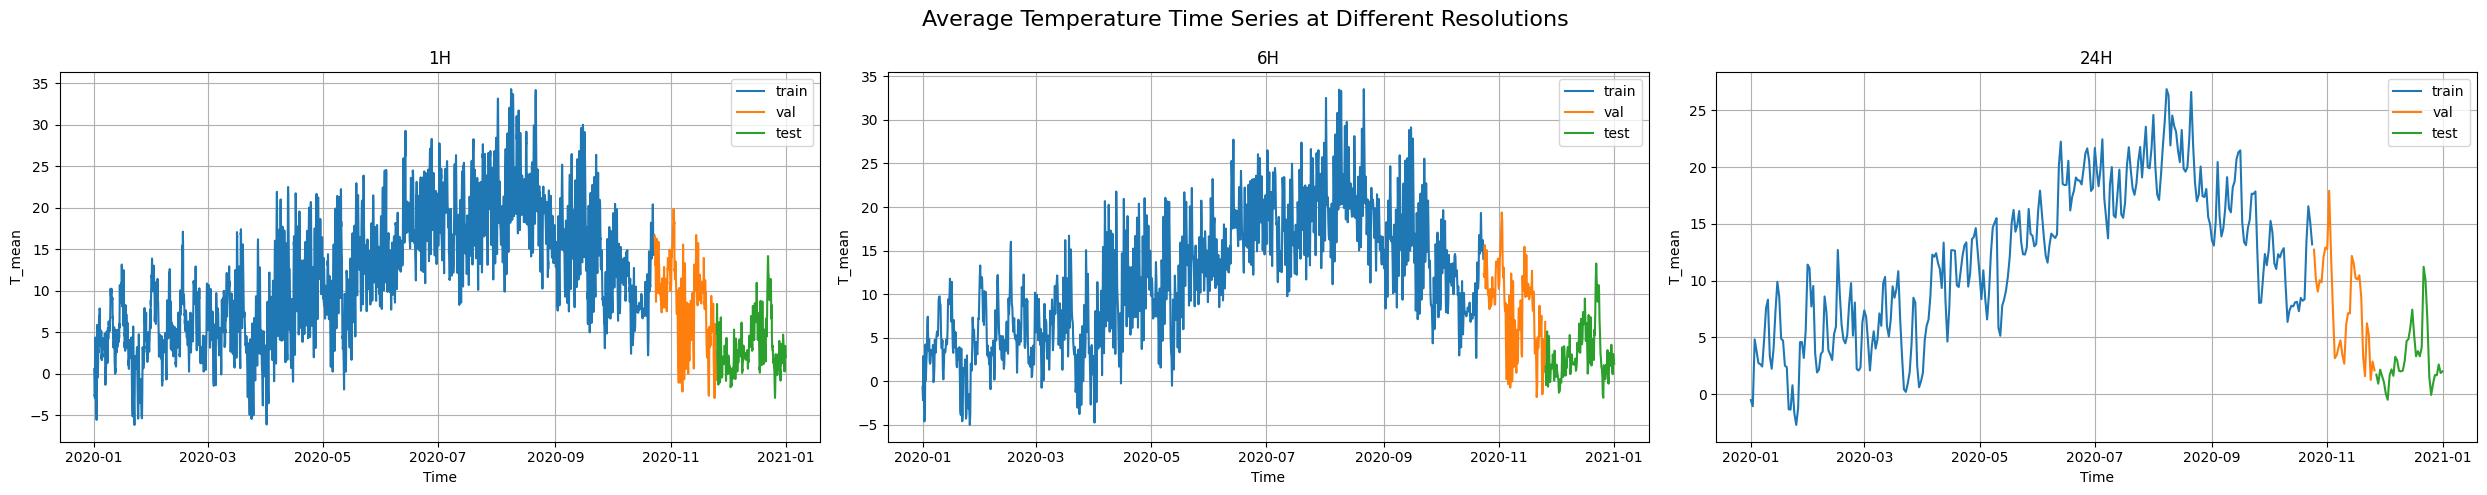

In [ ]:
# plot all series side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
fig.suptitle("Average Temperature Time Series at Different Resolutions", fontsize=16)

# 1H plot
axes[0].plot(hour_train.index, hour_train, label="train")
axes[0].plot(hour_val.index, hour_val, label="val")
axes[0].plot(hour_test.index, hour_test, label="test")
axes[0].set_title("1H")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("T_mean")
axes[0].legend()
axes[0].grid(True)

# 6H plot
axes[1].plot(six_train.index, six_train, label="train")
axes[1].plot(six_val.index, six_val, label="val")
axes[1].plot(six_test.index, six_test, label="test")
axes[1].set_title("6H")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("T_mean")
axes[1].legend()
axes[1].grid(True)

# 24H plot
axes[2].plot(day_train.index, day_train, label="train")
axes[2].plot(day_val.index, day_val, label="val")
axes[2].plot(day_test.index, day_test, label="test")
axes[2].set_title("24H")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("T_mean")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def normalize_series(series):
  """
  Normalizes a time series using z-score normalization: x_norm = (x - mean) / std

  Args:
      series (pd.Series or np.ndarray): Input time series.

  Returns:
      pd.Series: Normalized series (mean=0, std=1).
      float: Mean of the original series (for inverse transform).
      float: Std of the original series (for inverse transform).
  """
  mean = series.mean()
  std = series.std()

  norm_series = (series - mean) / (std + 1e-8)  # avoid dividing by zero
  return norm_series, mean, std

def denormalize(x_norm, mu, std):
  """
  Inverse of normalize_series.

  Args:
      x_norm (pd.Series or np.ndarray): Normalized time series.
      mu (float): Mean of the original series.
      std (float): Std of the original series.

  Returns:
      pd.Series: Denormalized series.
  """
  return x_norm * std + 1e-12 if std == 0 else x_norm * std + mu

In [ ]:
# normalize 1H, 6H, 24H temperature series
hour_train_norm, hour_train_mean, hour_train_std = normalize_series(hour_train)
hour_val_norm, hour_val_mean, hour_val_std = normalize_series(hour_val)
hour_test_norm, hour_test_mean, hour_test_std = normalize_series(hour_test)

six_train_norm, six_train_mean, six_train_std = normalize_series(six_train)
six_val_norm, six_val_mean, six_val_std = normalize_series(six_val)
six_test_norm, six_test_mean, six_test_std = normalize_series(six_test)

day_train_norm, day_train_mean, day_train_std = normalize_series(day_train)
day_val_norm, day_val_mean, day_val_std = normalize_series(day_val)
day_test_norm, day_test_mean, day_test_std = normalize_series(day_test)

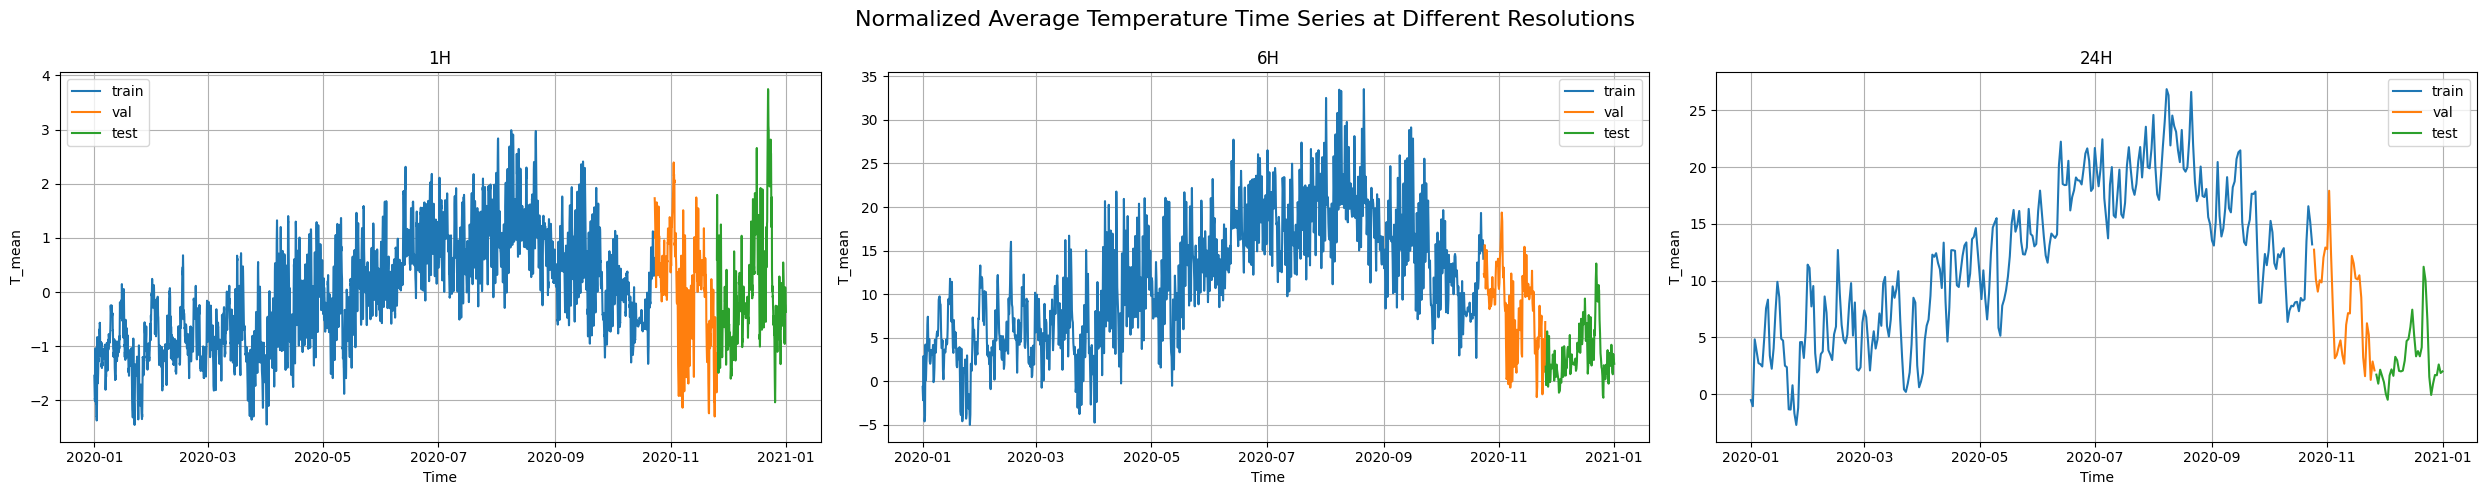

In [ ]:
# plot all normalized series side by side
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
fig.suptitle("Normalized Average Temperature Time Series at Different Resolutions", fontsize=16)

# 1H plot
axes[0].plot(hour_train_norm.index, hour_train_norm, label="train")
axes[0].plot(hour_val_norm.index, hour_val_norm, label="val")
axes[0].plot(hour_test_norm.index, hour_test_norm, label="test")
axes[0].set_title("1H")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("T_mean")
axes[0].legend()
axes[0].grid(True)

# 6H plot
axes[1].plot(six_train.index, six_train, label="train")
axes[1].plot(six_val.index, six_val, label="val")
axes[1].plot(six_test.index, six_test, label="test")
axes[1].set_title("6H")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("T_mean")
axes[1].legend()
axes[1].grid(True)

# 24H plot
axes[2].plot(day_train.index, day_train, label="train")
axes[2].plot(day_val.index, day_val, label="val")
axes[2].plot(day_test.index, day_test, label="test")
axes[2].set_title("24H")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("T_mean")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Create Sequences

We're working with a single-feature temperature series, but sequence models (RNNs/attention/Transformers) don't learn from a sequences as they need examples shaped as “past window → next value(s)”. So we convert the continuous series into overlapping sequences: each input $X$ is the last window_size points and the target $y$ is the next step (or next $H$ steps for multi-step). This yields 3D inputs $(N, window, features)$ where $features=1$ here. As starting point, we use windows that reflect common rhythms: for 1H data, 48 (2 days), for 6H, 56 (14 days x 4 slots/day) and for 24H, 28 (~1 month). These are naive baselines (for better results, we need to use validation to tune window size, horizon and stride for best accuracy).

In [ ]:
def create_sequences(data, window_size, target_col = None, horizon = 1, step = 1, ensure_3d: bool = True, verbose: bool = True):
  """
  Turns a (uni/multi-variate) time series into supervised samples using a sliding window.

  Args:
      data (pd.Series or pd.DataFrame): univariate or multivariate
        - If pd.Series: univariate input and target
        - If pd.DataFrame: multivariate input, and `target_col` must be specified
      window_size (int): number of past steps used as input.
      target_col (str): required if `data` is a DataFrame. The column used as the target
      horizon (int): number of future steps to predict (1 => next step)
      step (int): stride for the sliding window (default 1)
      ensure_3d: if True, returns X with shape (N, window_size, features)
                 if False and univariate, X will be (N, window_size)
      verbose: print shapes and summary information

  Returns:
      X: np.ndarray of shape (N, window_size, features) if ensure_3d else (N, window_size) for univariate.
      y: np.ndarray of shape (N,) for horizon=1, or (N, horizon) for horizon>1.
  """
  if isinstance(data, pd.DataFrame):
    features = data.columns.tolist()
    arr = data.values  # (Target, Features)
    tgt_idx = data.columns.get_loc(target_col)
    num_features = arr.shape[1]
  elif isinstance(data, pd.Series):
    features = [data.name if data.name is not None else "series"]
    arr = data.values.reshape(-1, 1)  # (Target, 1)
    tgt_idx = 0
    num_features = 1
  else:
    raise ValueError("data must be a pd.Series or pd.DataFrame")

  # drop NaNs rows consistently (if any)
  if isinstance(data, pd.DataFrame):
    mask = ~data.isna().any(axis=1)
  else:
    mask = ~data.isna()
  arr = arr[mask.values]

  X_list, y_list = [], []
  T = arr.shape[0]
  max_start = T - (window_size + horizon)

  for i in range(0, max_start + 1, step):
    past = arr[i : i + window_size] # (window_size, F)
    future = arr[i + window_size : i + window_size + horizon, tgt_idx]  # (horizon,)
    X_list.append(past)
    if horizon == 1:
      y_list.append(future[0])
    else:
      y_list.append(future)

  # RNNs expect 3D input shaped (N, window_size, features), so we keep the feature dim even for univariate (F=1) to avoid unsqueezing later
  # - X_list holds N windows, each `past` is (window_size, F) with F=1 for univariate.
  # - np.stack(X_list, axis=0) inserts a new leading axis and packs the N windows, [(window_size, F)] * N  -->  (N, window_size, F)
  X = np.stack(X_list).astype(np.float32) # (N, window_size, F)
  y = np.stack(y_list).astype(np.float32) if horizon > 1 else np.array(y_list, dtype=np.float32)  # (N,) for horizon=1, (N, horizon) elsewhere

  if verbose:
    print(f"Original length (after NaN filtering): {T}")
    print(f"Window size: {window_size}, Horizon: {horizon}, Step: {step}")
    print(f"Created samples: {len(X)}")
    print(f"X shape: {X.shape}  (features={num_features})")
    print(f"y shape: {y.shape}")
    print(f"X type: {type(X)}, y type: {type(y)}")
    print(f"X data types: {X.dtype}, y data types: {y.dtype}")
    if isinstance(data, pd.DataFrame):
      print(f"Features: {features} | Target: {target_col}")
    else:
      print(f"Feature (+Target): {features[0]}")

  return X, y

In [ ]:
# set window sizes
hour_window_size = 48
six_window_size = 56
day_window_size = 28

In [ ]:
# create sequences

# 1H sequences (horizon=1)
print("1H Train Sequences")
X_h_train, y_h_train = create_sequences(hour_train_norm, window_size=hour_window_size, horizon=1)
print("\n1H Validation Sequences")
X_h_val, y_h_val = create_sequences(hour_val_norm, window_size=hour_window_size, horizon=1)
print("\n1H Test Sequences")
X_h_test, y_h_test = create_sequences(hour_test_norm, window_size=hour_window_size, horizon=1)

# 1H sequences (horizon=6)
# print("\n1H Train Sequences for Horizon=6")
# X_h6_train, y_h6_train = create_sequences(hour_train_norm, window_size=hour_window_size, horizon=6)
# print("\n1H Validation Sequences for Horizon=6")
# X_h6_val, y_h6_val = create_sequences(hour_val_norm, window_size=hour_window_size, horizon=6)
# print("\n1H Test Sequences for Horizon=6")
# X_h6_test, y_h6_test = create_sequences(hour_test_norm, window_size=hour_window_size, horizon=6)

# 6H sequences (horizon=1)
print("\n6H Train Sequences")
X_6_train, y_6_train = create_sequences(six_train_norm, window_size=six_window_size, horizon=1)
print("\n6H Validation Sequences")
X_6_val, y_6_val = create_sequences(six_val_norm, window_size=six_window_size, horizon=1)
print("\n6H Test Sequences")
X_6_test, y_6_test = create_sequences(six_test_norm, window_size=six_window_size, horizon=1)

# 6H sequences (horizon=6)
# print("\n6H Train Sequences for Horizon=6")
# X_64_train, y_64_train = create_sequences(six_train_norm, window_size=six_window_size, horizon=6)
# print("\n6H Validation Sequences for Horizon=6")
# X_64_val, y_64_val = create_sequences(six_val_norm, window_size=six_window_size, horizon=6)
# print("\n6H Test Sequences for Horizon=6")
# X_64_test, y_64_test = create_sequences(six_test_norm, window_size=six_window_size, horizon=6)

# 24H sequences (horizon=1)
print("\n24H Train Sequences")
X_24_train, y_24_train = create_sequences(day_train_norm, window_size=day_window_size, horizon=1)
print("\n24H Validation Sequences")
X_24_val, y_24_val = create_sequences(day_val_norm, window_size=day_window_size, horizon=1)
print("\n24H Test Sequences")
X_24_test, y_24_test = create_sequences(day_test_norm, window_size=day_window_size, horizon=1)

1H Train Sequences
Original length (after NaN filtering): 7116
Window size: 48, Horizon: 1, Step: 1
Created samples: 7068
X shape: (7068, 48, 1)  (features=1)
y shape: (7068,)
X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X data types: float32, y data types: float32
Feature (+Target): T

1H Validation Sequences
Original length (after NaN filtering): 790
Window size: 48, Horizon: 1, Step: 1
Created samples: 742
X shape: (742, 48, 1)  (features=1)
y shape: (742,)
X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X data types: float32, y data types: float32
Feature (+Target): T

1H Test Sequences
Original length (after NaN filtering): 878
Window size: 48, Horizon: 1, Step: 1
Created samples: 830
X shape: (830, 48, 1)  (features=1)
y shape: (830,)
X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X data types: float32, y data types: float32
Feature (+Target): T

6H Train Sequences
Original length (after NaN filtering): 1188
Window size: 56, 

In [ ]:
# preview a sample (of normalized sequences)
print("1H Train X[0]:\n", X_h_train[0])
print("\n1H Train y[0]:\n", y_h_train[0])

1H Train X[0]:
 [[-1.5431594 ]
 [-1.601803  ]
 [-1.6414512 ]
 [-1.7034997 ]
 [-1.8112444 ]
 [-1.9169731 ]
 [-1.9792455 ]
 [-1.9635655 ]
 [-2.0153098 ]
 [-2.0146377 ]
 [-1.8067644 ]
 [-1.6994677 ]
 [-1.4161056 ]
 [-1.1611919 ]
 [-1.1085515 ]
 [-1.035527  ]
 [-1.2127123 ]
 [-1.4450018 ]
 [-1.618155  ]
 [-1.8027323 ]
 [-1.9003971 ]
 [-2.020686  ]
 [-2.064814  ]
 [-2.051374  ]
 [-2.1237266 ]
 [-2.206159  ]
 [-2.213103  ]
 [-2.2841117 ]
 [-2.2838876 ]
 [-2.325104  ]
 [-2.3690083 ]
 [-2.2993438 ]
 [-2.3147998 ]
 [-2.203695  ]
 [-2.050254  ]
 [-1.6882676 ]
 [-1.2772247 ]
 [-0.83034164]
 [-0.8406457 ]
 [-0.88253397]
 [-1.1544719 ]
 [-1.3397211 ]
 [-1.5005542 ]
 [-1.6698995 ]
 [-1.6846836 ]
 [-1.6459312 ]
 [-1.5823148 ]
 [-1.5377386 ]]

1H Train y[0]:
 -1.5079463


### Create DataLoaders

In [ ]:
# demonstration of shape behavior when working with NumPy arrays vs PyTorch tensors
XX = np.zeros((2,2))
for i in range(2):
  for j in range(2):
    XX[i,j] = 2
print(XX, XX.shape)
print(f"\nXX[0][0] shape: {XX[0][0].shape}")
print(f"XX[0][0] value: {XX[0][0]}\n")

XX = torch.tensor(XX)
print(XX, XX.shape)

print(f"\nXX[0][0] shape: {XX[0][0].shape}")  # scalar (0D tensor)
print(f"XX[0][0] value: {XX[0][0]}\n")

XX = XX.unsqueeze(-1)
print(XX, XX.shape)

print(f"\nXX[0][0] shape: {XX[0][0].shape}")  # shape of (1,) while XX is of shape (2, 2, 1)
print(f"XX[0][0] value: {XX[0][0]}")

[[2. 2.]
 [2. 2.]] (2, 2)

XX[0][0] shape: ()
XX[0][0] value: 2.0

tensor([[2., 2.],
        [2., 2.]], dtype=torch.float64) torch.Size([2, 2])

XX[0][0] shape: torch.Size([])
XX[0][0] value: 2.0

tensor([[[2.],
         [2.]],

        [[2.],
         [2.]]], dtype=torch.float64) torch.Size([2, 2, 1])

XX[0][0] shape: torch.Size([1])
XX[0][0] value: tensor([2.], dtype=torch.float64)


In [ ]:
def to_loader(X, y, batch_size=32):
  """
  Creates a DataLoader from a NumPy array.

  Args:
      X: np.ndarray of shape (N, window_size, features)
      y: np.ndarray of shape (N,) for horizon=1, or (N, horizon)
      batch_size: int

  Returns:
      data_loader: torch.utils.data.DataLoader
  """
  tensor_x = torch.from_numpy(X).float()  # (N, L, F)
  tensor_y = torch.from_numpy(y).float()
  if tensor_y.ndim == 1:
    tensor_y = tensor_y.view(-1, 1)  # (N, 1)

  tensor_dataset = TensorDataset(tensor_x, tensor_y)
  data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  return data_loader

In [ ]:
# create dataloaders
hour_train_loader = to_loader(X_h_train, y_h_train)
hour_val_loader = to_loader(X_h_val, y_h_val)
hour_test_loader = to_loader(X_h_test, y_h_test)

# hour6_train_loader = to_loader(X_h6_train, y_h6_train)
# hour6_val_loader = to_loader(X_h6_val, y_h6_val)
# hour6_test_loader = to_loader(X_h6_test, y_h6_test)

six_train_loader = to_loader(X_6_train, y_6_train)
six_val_loader = to_loader(X_6_val, y_6_val)
six_test_loader = to_loader(X_6_test, y_6_test)

# six4_train_loader = to_loader(X_64_train, y_64_train)
# six4_val_loader = to_loader(X_64_val, y_64_val)
# six4_test_loader = to_loader(X_64_test, y_64_test)

day_train_loader = to_loader(X_24_train, y_24_train)
day_val_loader = to_loader(X_24_val, y_24_val)
day_test_loader = to_loader(X_24_test, y_24_test)

In [ ]:
# before conversion
print("Before conversion:")
print("X_day_train shape:", X_24_train.shape)
print("Example x^(t) (X_day_train[0][0]) shape:", X_24_train[0][0].shape)
print("Example x^(t) (X_day_train[0][0]) value:", X_24_train[0][0])
print("Example x^(t) type:", X_24_train[0][0].dtype)

# after conversion
print("\nAfter conversion:")
print("Num batches in day_train_loader:", len(day_train_loader))

# inspect the underlying dataset
ds = day_train_loader.dataset
print("Dataset length (samples):", len(ds))
x0, y0 = ds[0]  # (T, F), (1,) or (T, F)
print("\nDataset sample X shape:", x0.shape)
print("Dataset sample y shape:", y0.shape if hasattr(y0, "shape") else type(y0))
print("Example x^(t) (dataset sample X[0][0]) shape:", x0[0].shape)  # (F,)
print("Example x^(t) (dataset sample X[0][0]) value:", x0[0])
print("Example y value:", y0.item())

# grab the first batch from the loader
xb, yb = next(iter(day_train_loader))  # xb: (B, T, F), yb: (B, 1) or (B,)
print("\nFirst batch X shape:", xb.shape)
print("First batch y shape:", yb.shape)
print("Example x^(t) (batch sample X[0,0]) shape:", xb[0, 0].shape)  # (F,)
print("Example x^(t) (batch sample X[0,0]) value:", xb[0, 0])
print("Example y value:", yb[0].item())
print("Tensor dtypes -> X:", xb.dtype, "| y:", yb.dtype)

Before conversion:
X_day_train shape: (270, 28, 1)
Example x^(t) (X_day_train[0][0]) shape: (1,)
Example x^(t) (X_day_train[0][0]) value: [-1.9179299]
Example x^(t) type: float32

After conversion:
Num batches in day_train_loader: 9
Dataset length (samples): 270

Dataset sample X shape: torch.Size([28, 1])
Dataset sample y shape: torch.Size([1])
Example x^(t) (dataset sample X[0][0]) shape: torch.Size([1])
Example x^(t) (dataset sample X[0][0]) value: tensor([-1.9179])
Example y value: -1.352818489074707

First batch X shape: torch.Size([32, 28, 1])
First batch y shape: torch.Size([32, 1])
Example x^(t) (batch sample X[0,0]) shape: torch.Size([1])
Example x^(t) (batch sample X[0,0]) value: tensor([-1.9179])
Example y value: -1.352818489074707
Tensor dtypes -> X: torch.float32 | y: torch.float32


## RNNs

### Custom RNN

(Architecture 1): Recurrent Hidden State Connections with Output Prediction at Every Time Step.

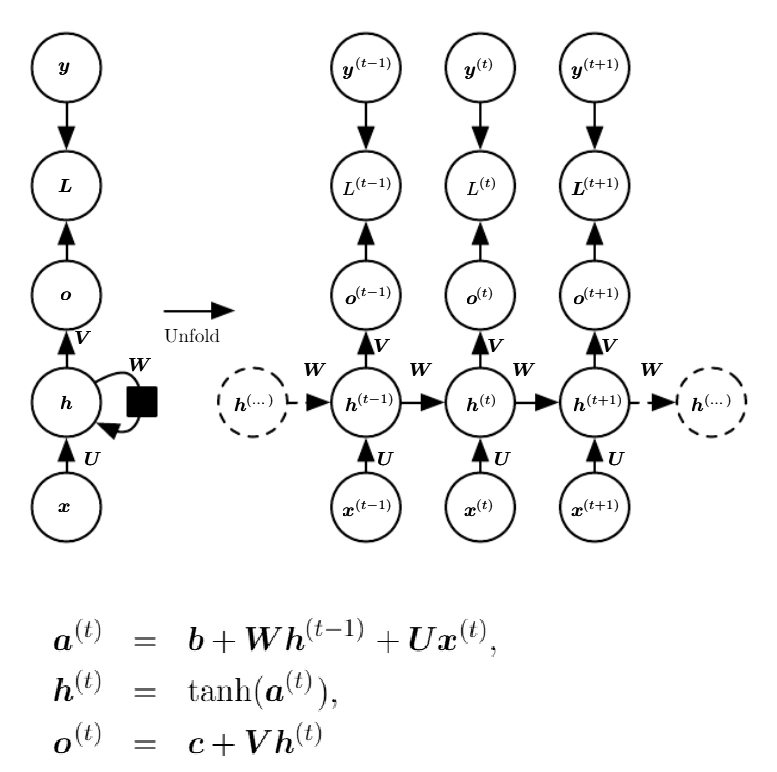

In [ ]:
# helper functions

def r2_fn(y_trues, y_preds):
  """
  Calculates the R² score for regression ("How well is the model explaining the variance of the target?").

  Args:
    - y_trues: list or tensor of true target values (e.g. actual temperatures)
    - y_preds: list or tensor of predicted values from the model

  Returns:
    - R² score: a float in (-∞, 1], where 1.0 is perfect prediction

  Definition:
    R² measures how well the predicted values approximate the actual values.

    R² = 1 - (SS_residual / SS_total), where:

      SS_residual = Σ(yᵢ - ŷᵢ)²  → the sum of squared errors (model residuals)
      SS_total    = Σ(yᵢ - ȳ)²   → the total variance in the data (relative to mean)

  Interpretation:
    - R² = 1 → perfect prediction
    - R² = 0 → model does no better than mean
    - R² < 0 → model is worse than just predicting the mean
  """
  if not isinstance(y_trues, torch.Tensor):
    y_trues = torch.tensor(y_trues, dtype=torch.float32)
  if not isinstance(y_preds, torch.Tensor):
    y_preds = torch.tensor(y_preds, dtype=torch.float32)

  # flatten tensors to work for (N,), (N,1), multi-horizon (N,H)
  y_trues = y_trues.reshape(-1)
  y_preds = y_preds.reshape(-1)

  ss_total = torch.sum((y_trues - y_trues.mean()) ** 2)
  ss_residual = torch.sum((y_trues - y_preds) ** 2)

  r2 = 1.0 - ss_residual / (ss_total - 1e-8) # results a tensor
  return float(r2)  # return a float number


def plot_history(history):
  """
  Plots train/val Loss and R².

  Args:
    - history: dictionary with keys 'train_loss', 'val_loss', 'train_r2', 'val_r2'
  """
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  fig.suptitle('Training & Validation Curves', fontsize=14)

  # loss
  ax1.plot(history['train_loss'], label='Train Loss')
  ax1.plot(history['val_loss'],   label='Val Loss')
  ax1.set_title('Loss Curves')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.grid(True)

  # R²
  ax2.plot(history['train_r2'], label='Train')
  ax2.plot(history['val_r2'],   label='Val')
  ax2.set_title('R² Curves')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('R²')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()


def plot_residuals_preds(y_true, y_pred, index=None, feature_name="T", date_fmt="%Y-%m-%d %H:%M", h=None):
  """
  Side-by-side plots: residuals (y_true - y_pred) and Test vs Predictions.

  Args:
      y_true (np.ndarray | pd.Series): Ground truth. Shape (N,) for one-step pred or (N,H) for multi-step pred
      y_pred (np.ndarray | pd.Series): Predictions. Shape (N,) for one-step pred or (N,H) for multi-step pred
      index (pd.Index | None): Optional x-axis index for plotting (e.g. DateTimeIndex)
      feature_name (str): Y-axis label for Test vs Predictions
      date_fmt (str): Datetime tick format if index is datetime-like
      h (int | None): For 1-step is None, for multi-step is (h-1) as is 0-based
  """
  # to numpy
  yt = y_true.values if isinstance(y_true, pd.Series) else np.asarray(y_true)
  yp = y_pred.values if isinstance(y_pred, pd.Series) else np.asarray(y_pred)

  # - Else -> flatten all horizons to one long vector and drop datetime index.
  if yt.ndim == 2 and yp.ndim == 2:
    if h is not None:
      yt, yp = yt[:, h], yp[:, h] # 1-step case: pick the one horizon
    else:
      yt, yp = yt.reshape(-1), yp.reshape(-1) # multi-step case: flatten all horizons
      index = None # no dates when flattened

  # align lengths
  n = min(len(yt), len(yp))
  yt, yp = yt[:n], yp[:n]

  # x-axis: use given pandas index if valid/long enough
  use_idx = isinstance(index, pd.Index) and len(index) >= n
  x = (index[:n] if use_idx else np.arange(n))

  # residuals
  res = yt - yp

  # plots
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].plot(x, res, label="Residuals")
  axes[0].axhline(0, ls="--", color="r", lw=1)
  axes[0].set_title("Residuals")
  axes[0].set_xlabel("Time")
  axes[0].set_ylabel("Error")
  axes[0].legend()

  axes[1].plot(x, yt, label="Test")
  axes[1].plot(x, yp, label="Pred")
  axes[1].set_title("Test vs Predictions")
  axes[1].set_xlabel("Time")
  axes[1].set_ylabel(feature_name)
  axes[1].legend()

  # datetime formatting
  if use_idx and pd.api.types.is_datetime64_any_dtype(index):
    for ax in axes:
      ax.xaxis.set_major_locator(mdates.AutoDateLocator())
      ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
      for lbl in ax.get_xticklabels():
        lbl.set_rotation(45); lbl.set_ha("right")

  plt.tight_layout()
  plt.show()


def count_trainable_params(params):
  """
  Counts the total number of trainable params. This will be used for capacity comparisons between simple and more complex deep neural networks.

  Args:
    - params: list of torch.nn.Parameter objects

  Returns:
    - total number of trainable params
  """
  return sum(p.numel() for p in params if p.requires_grad)


def evaluate_model(y_true, y_pred):
  """
  Computes MAE, RMSE, and MAPE (%) and return them as formatted strings.

  Args:
      y_true (array-like): Ground truth values
      y_pred (array-like): Model predictions
  """
  # ensure y_true and y_pred are of the same lengths
  if len(y_true) != len(y_pred):
    raise ValueError("Input arrays must have the same length.")

  # MAE: mean absolute error
  mae = np.mean(np.abs(y_true - y_pred))

  # RMSE: root mean squared error
  rmse = np.sqrt(np.mean((y_true - y_pred)**2))

  # MAPE: mean absolute percentage error
  denom = np.clip(np.abs(y_true), 1e-8, None)  # if 0 -> use 1e-8 (avoid division by zero)
  mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100

  return (f"{mae:.2f}", f"{rmse:.2f}", f"{mape:.2f}")


def plot_learning_curves_all(histories, resolution_labels):
  """
  Plots train/val loss and accuracy curves for multiple time resolutions.

  Args:
      histories (list of dict): Each dict must contain keys: 'train_loss', 'val_loss', 'train_r2', 'val_r2'
      resolution_labels (list of str): Labels like ["1H", "6H", "24H"]
  """
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True)
  fig.suptitle("Training & Validation Curves per Time Resolution", fontsize=14)

  for i, (history, label) in enumerate(zip(histories, resolution_labels)):
    # plot loss
    axes[i, 0].plot(history['train_loss'], label='Train Loss')
    axes[i, 0].plot(history['val_loss'], label='Val Loss')
    axes[i, 0].set_ylabel(f'{label} Loss')
    axes[i, 0].set_title(f'{label} Time Resolution')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # plot accuracy
    axes[i, 1].plot(history['train_r2'], label='Train R²')
    axes[i, 1].plot(history['val_r2'], label='Val R²')
    axes[i, 1].set_ylabel(f'{label} R²')
    axes[i, 1].set_title(f'{label} Time Resolution')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

  axes[2, 0].set_xlabel("Epoch")
  axes[2, 1].set_xlabel("Epoch")
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

In [ ]:
def train_custom_rnn(train_loader, val_loader, input_size=1, hidden_size=64, output_size=1, epochs=100, lr=1e-3, verbose_every=10, weight_decay=1e-4):
  """
  Trains a manual RNN using matrix equations:
    a^(t) = Ux^(t) + Wh^(t-1) + b
    h^(t) = tanh(a^(t))
    o^(t) = Vh^(t) + c

  Args:
    - train_loader: (N, L, 1) dataloader of input sequences
    - val_loader: (N, L, 1) dataloader of input sequences
    - input_size: number of input features per time step (1 for univariate)
    - hidden_size: size of hidden state units
    - output_size: output size (1 for univariate regression)
    - epochs: number of training iterations
    - lr: learning rate
    - verbose_every: print loss every N epochs
    - weight_decay: L2 regularization weight

  Returns:
    - params: list of learned model parameters [U, W, V, b, c]
    - history: dictionary with keys 'loss' and 'r2', storing per-epoch values
    - total_training_time: float, total training time in seconds
    - total_params: int, total number of trainable parameters
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # model's learnable params
  U = nn.Parameter(torch.randn(hidden_size, input_size, device=device))  # (hidden_size, 1)
  W = nn.Parameter(torch.randn(hidden_size, hidden_size, device=device)) # (hidden_size, hidden_size)
  V = nn.Parameter(torch.randn(output_size, hidden_size, device=device)) # (1, hidden_size), see first equation and notice h(t) is of shape (hidden_size, 1)
  b = nn.Parameter(torch.zeros(hidden_size, 1, device=device))  # (hidden_size, 1)
  c = nn.Parameter(torch.zeros(output_size, 1, device=device))  # (1, 1)

  # apply weight initialization
  nn.init.xavier_uniform_(U)
  nn.init.xavier_uniform_(W)
  nn.init.xavier_uniform_(V)

  params = [U, W, V, b, c]

  # set optimizer and loss function
  optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
  loss_fn = nn.MSELoss()

  # history tracking
  history = {'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': [] }

  # early stopping setup
  patience = 10
  best_val_loss = float('inf')
  best_state = [p.detach().clone() for p in params]  # clone_params
  no_improve = 0
  stopped_epoch = 0

  # training step
  start_time = time.time()
  for epoch in range(epochs):
    total_loss, num_seen = 0.0, 0 # num_seen helps to count the exact len of batches (in case of not full size batches!)
    train_preds, train_targets = [], []

    # iterate over all mini batches of train dataloader
    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      batch_len = X_batch.shape[0]  # (batch_size, sequence_length, input_size)
      batch_losses = []

      # iterate over all rows (records) of the batch
      for i in range(batch_len):
        x_seq = X_batch[i]  # (L, 1) -> (24, 1) in our case
        y_t = y_batch[i].reshape(-1)  # (1,) (output_size,)

        # initialize h_t
        h_t = torch.zeros((hidden_size, 1), device=device)  # (hidden_size, 1)

        # iterate over all time instances to compute h_t
        for t in range(x_seq.shape[0]):
          x_t = x_seq[t]  # (1,) (input_size,), input at time t
          x_t = x_t.unsqueeze(-1)  # (1,) -> (1, 1) (input_size, 1) -> now is appropriate for multiplication
          a_t = U @ x_t + W @ h_t + b  # [(hidden_size, 1) @ (1, 1) + (hidden_size, hidden_size) @ (hidden_size, 1) + (hidden_size, 1) = (hidden_size, 1)
          h_t = torch.tanh(a_t) # (hidden_size, 1)

        # compute the final prediction
        o_t = V @ h_t + c  # (1, hidden_size) @ (hidden_size, 1) + (1, 1) = (1, 1)

        # convert o_t to scalar
        y_pred = o_t.reshape(-1)  # (1, 1) -> (1,) (output_size,)

        # compute and store loss, y_preds and y_trues
        batch_losses.append(loss_fn(y_pred, y_t)) # scalar (both are of shpe (1,))

        train_preds.append(y_pred.detach().flatten()) # train_preds.append(y_pred.item())
        train_targets.append(y_t.detach().flatten())  # train_targets.append(y_t.item())

      # backprop once per batch
      loss = torch.stack(batch_losses).mean()
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(params, max_norm=5.0)  # add gradient clipping to prevent exploding gradients during backpropagation
      optimizer.step()

      total_loss += loss.item() * X_batch.size(0)  # weight by batch size
      num_seen   += X_batch.size(0)

    # compute total average loss (total loss / len(loader))
    avg_total_loss = total_loss / max(1, num_seen) # len(train_loader)
    train_r2 = r2_fn(torch.cat(train_targets), torch.cat(train_preds)) # r2_fn(train_targets, train_preds)

    # validation step
    val_total_loss, val_seen = 0.0, 0
    val_preds, val_targets = [], []

    with torch.no_grad(): # disable gradient tracking as we make just forward pass here
      for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_losses = []

        for i in range(X_batch.shape[0]):
          x_seq = X_batch[i]
          y_t = y_batch[i].reshape(-1)

          h_t = torch.zeros((hidden_size, 1), device=device)

          # we loop over each timestep for each sequence separately (a faster vectorized version would update h_t for the whole batch at once!)
          for t in range(x_seq.shape[0]):
            x_t = x_seq[t].unsqueeze(-1)
            a_t = U @ x_t + W @ h_t + b
            h_t = torch.tanh(a_t)

          o_t = V @ h_t + c
          y_pred = o_t.reshape(-1)

          batch_losses.append(loss_fn(y_pred, y_t))
          val_preds.append(y_pred.detach().flatten()) # val_preds.append(y_pred.item())
          val_targets.append(y_t.detach().flatten()) # val_targets.append(y_t.item())

        val_loss = torch.stack(batch_losses).mean().item()
        val_total_loss += val_loss * X_batch.size(0)
        val_seen += X_batch.size(0)

    avg_val_loss = val_total_loss / max(1, val_seen)
    val_r2 = r2_fn(torch.cat(val_targets), torch.cat(val_preds)) # r2_fn(val_targets, val_preds)

    # store all metrics
    history['train_loss'].append(avg_total_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)

    if (epoch + 1) % verbose_every == 0:
      print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_total_loss:.4f}, Train R²: {train_r2:.4f} | Val Loss: {avg_val_loss:.4f}, Val R²: {val_r2:.4f}")

    # early stopping update
    if avg_val_loss + 1e-8 < best_val_loss:
      best_val_loss = avg_val_loss
      best_state = [p.detach().clone() for p in params]
      no_improve = 0
    else:
      no_improve += 1
      if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} (no val loss improvement for {patience} epochs).")
        stopped_epoch = epoch + 1
        break

  end_time = time.time()
  total_training_time = end_time - start_time
  print(f"\nTotal training time: {total_training_time:.2f} seconds")

  # count total trainable params
  total_params = count_trainable_params(params)
  print(f"Total trainable parameters: {total_params}\n")

  # restore best weights
  for p, bp in zip(params, best_state):
    p.data.copy_(bp)
  best_params = [p.detach().clone() for p in params]

  # also save stopped epoch
  if stopped_epoch == 0:
    stopped_epoch = epoch + 1

  history.update({'params': best_params, # best (early-stopped) parameters
                  'total_training_time': round(total_training_time, 4),
                  'total_params': total_params,
                  'best_val_loss': float(best_val_loss),
                  'stopped_epoch': stopped_epoch
                  })

  return history


# @torch.no_grad()
# def predict_custom_rnn(params, data_loader, hidden_size, n_steps=1, device=None):
#   """
#   Recursive n_step predictions predictions with a manual RNN using matrix equations:
#     a^(t) = Ux^(t) + Wh^(t-1) + b
#     h^(t) = tanh(a^(t))
#     o^(t) = Vh^(t) + c

#   Args:
#     - params: list of learned model parameters [U, W, V, b, c]
#     - data_loader: (N, L, 1) dataloader of input sequences
#     - hidden_size: size of hidden state units
#     - n_steps: number of steps to predict (1 for univariate regression)
#     - device: device to use for training (cpu or cuda)

#     Returns:
#     - y_pred_norm: normalized predictions (N,) if n_steps=1 else (N, n_steps)
#     - y_true_norm: normalized targets of same shape if available from loader, else None
#   """
#   device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

#   # move params to device
#   U, W, V, b, c = [p.to(device) for p in params]
#   preds, trues = [], []

#   for Xb, yb in data_loader:
#     Xb, yb = Xb.to(device), yb.to(device)

#     for i in range(Xb.shape[0]):
#       x_seq = Xb[i] # (L, F)
#       # initialize hidden state
#       h_t = torch.zeros((hidden_size, 1), device=device)

#       # get h_t for the current sequence
#       for t in range(x_seq.shape[0]):
#         x_t = x_seq[t].unsqueeze(-1) # (F,1)
#         a_t = U @ x_t + W @ h_t + b
#         # print(a_t.shape, h_t.shape)
#         # print("U @ x_t:", (U @ x_t).shape)
#         # print("W @ h_t:", (W @ h_t).shape)
#         # print("b:", b.shape)
#         h_t = torch.tanh(a_t) # (hidden_size, 1)/(Out,1)

#       # recursive

#       o_t = V @ h_t + c # (Out,1)
#       y_hat = o_t.squeeze() # (Out,) or scalar

#       preds.append(y_hat.detach().cpu().flatten())
#       trues.append(yb[i].detach().cpu().flatten())

#   y_pred = torch.stack(preds) if preds else torch.empty(0)
#   y_true = torch.stack(trues) if trues else torch.empty(0)

#   # squeeze to 1D for 1-step
#   if y_pred.ndim == 2 and y_pred.shape[1] == 1:
#     y_pred = y_pred[:, 0]
#     y_true = y_true[:, 0]
#   return y_pred.numpy(), y_true.numpy()


@torch.no_grad()
def predict_custom_rnn(data_loader, params, n_steps=1):
  """
  Makes 1-step or n-step ahead predictions with our manual RNN.

  Args:
    - data_loader: yields (Xb, yb) where Xb has shape (B, L, 1). yb can be ignored or used for alignment
    - params: list [U, W, V, b, c] from trained model
    - n_steps: how many steps ahead to predict (default: 1)

  Returns:
    - preds_last: (N,) last-step predictions (t+n_steps)
    - trues_last: (N,) last-step ground truths
    - preds_rollout: (N, n_steps) full recursive rollout [t+1 ... t+n_steps]
    - trues_rollout: (N, n_steps) matching ground truths
  """
  # device handling + params
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  U, W, V, b, c = params
  U, W, V, b, c = [p.to(device) for p in (U, W, V, b, c)]
  hidden_size = W.shape[0]  # extract hidden size

  # collectors
  preds_last, trues_last = [], []
  preds_rollout, trues_rollout = [], []

  for Xb, yb in data_loader:
    Xb, yb = Xb.to(device), yb.to(device) # move batch to device
    B, L = Xb.shape[0], Xb.shape[1]  # B batch size (e.g. 32), L sequence length (e.g. 24)

    for i in range(B):
      input_seq = Xb[i] # (L, 1)
      y_i = yb[i].view(-1)  # (1,) or (n_steps,)

      # build initial h_t from the full input sequence
      h_t = torch.zeros(hidden_size, 1, device=device)  # initialize hidden state
      for t in range(input_seq.shape[0]):
        x_t = input_seq[t].view(1, 1) # force (1, 1) # input_seq[t].unsqueeze(-1)  # (1,) -> (1, 1)
        a_t = U @ x_t + W @ h_t + b
        # print(a_t.shape, h_t.shape)
        # print("U @ x_t:", (U @ x_t).shape)
        # print("W @ h_t:", (W @ h_t).shape)
        # print("b:", b.shape)
        h_t = torch.tanh(a_t) # (hidden_size, 1)

      # print(h_t.shape)

      # autoregressive prediction:
      # during training, the RNN updates its hidden state using the true input at each time step and the previous hidden state, while
      # at prediction time, where future true inputs are unavailable, we adopt an autoregressive strategy when we have to predict n_steps away:
      # each new prediction is fed back as the next input. The same happens to all below cases!

      # recursive rollout for n_steps (start from last observed value)
      last_input = input_seq[-1].view(1, 1) #.unsqueeze(-1)  # last observed value -> (1, 1)
      # print(last_input.shape)

      step_preds = []  # for collecting n_steps per sample
      y_pred_last = None
      for _ in range(n_steps):
        a_t = U @ last_input + W @ h_t + b
        h_t = torch.tanh(a_t)
        # print(V.shape, h_t.shape, c.shape)
        o_t = V @ h_t + c # (1, 1)
        # print(o_t.shape)

        y_hat  = o_t.view(-1)           # tensor, shape (1,)
        y_pred = o_t.squeeze().item()  # extract scalar prediction
        step_preds.append(y_pred)

        # next last_input is the current prediction (autoregression)
        last_input = y_hat.view(1, 1)
        # print("last_input.shape:", last_input.shape)

      # store predictions for this sample
      preds_rollout.append(step_preds) # (n_steps,)
      preds_last.append(step_preds[-1]) # last only

      # store truths (assumes dataset provides matching horizon)
      if n_steps == 1 and y_i.numel() == 1:
        trues_rollout.append([float(y_i.item())])  # shape (1,) -> list for stack
        trues_last.append(float(y_i.item()))
      elif n_steps > 1 and y_i.numel() >= n_steps:
        # take the first n_steps as the target rollout; last is t+n_steps
        yi_np = y_i[:n_steps].detach().cpu().numpy().astype(float)
        trues_rollout.append(yi_np.tolist())
        trues_last.append(float(yi_np[-1]))
      else:
        raise ValueError(f"Ground-truth horizon mismatch: got {y_i.numel()} labels but n_steps={n_steps}.")

  # to numpy
  preds_last_np = np.asarray(preds_last, dtype=float) # (N,)
  trues_last_np = np.asarray(trues_last, dtype=float) # (N,)
  preds_rollout_np = np.asarray(preds_rollout, dtype=float) # (N, n_steps)
  trues_rollout_np = np.asarray(trues_rollout, dtype=float) # (N, n_steps)

  return preds_last_np, trues_last_np, preds_rollout_np, trues_rollout_np

1H resolution model's training (horizon=1)
Epoch 10/100, Train Loss: 0.0081, Train R²: 0.9918 | Val Loss: 0.0147, Val R²: 0.9850
Early stopping at epoch 17 (no val loss improvement for 10 epochs).

Total training time: 1402.05 seconds
Total trainable parameters: 4289



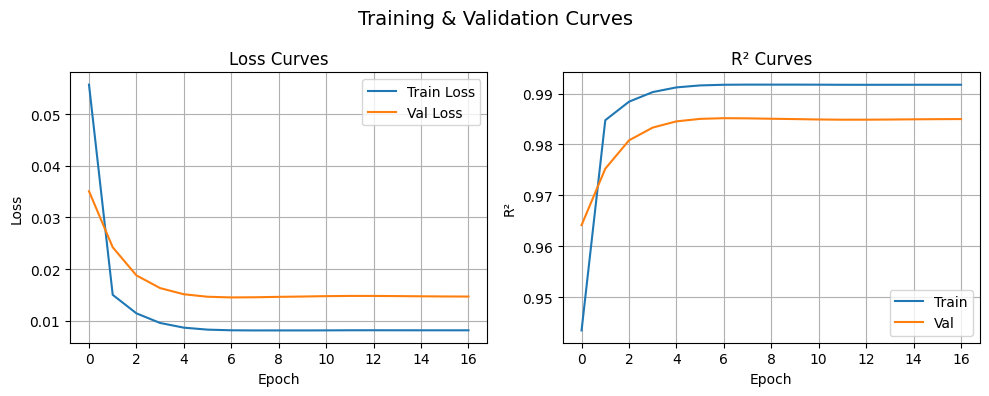

In [ ]:
# 1H custom RNN training (horizon=1)
print("1H resolution model's training (horizon=1)")
history1h_1h = train_custom_rnn(hour_train_loader, hour_val_loader)

# plot learning curves
plot_history(history1h_1h)

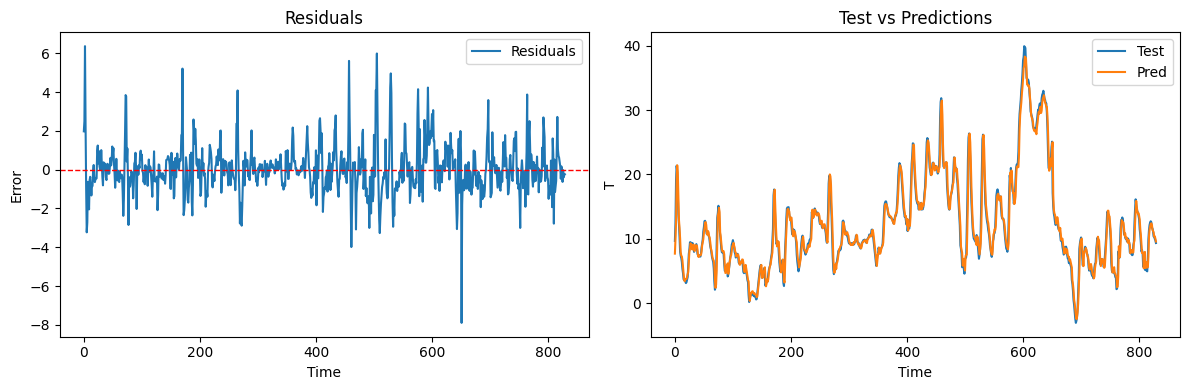


1H series (1 steps-ahead forecasts)
1H Custom RNN Training Time: 1402.0469
1H Custom RNN Total Params: 4289
1H Custom RNN: MAE=0.86, RMSE=1.25, MAPE=11.15


In [ ]:
# predict (1-step ahead with 1H model)
crnn_preds1h_1h_last_norm, crnn_trues1h_1h_last_norm, _, _ = predict_custom_rnn(hour_test_loader, history1h_1h['params'])

# denormalize, plot and evaluate
crnn_preds1h_1h = denormalize(crnn_preds1h_1h_last_norm, hour_train_mean, hour_train_std)
crnn_trues1h_1h = denormalize(crnn_trues1h_1h_last_norm, hour_train_mean, hour_train_std)
plot_residuals_preds(crnn_trues1h_1h, crnn_preds1h_1h)
mae1, rmse1, mape1 = evaluate_model(crnn_trues1h_1h, crnn_preds1h_1h)

print("\n1H series (1 steps-ahead forecasts)")
print("1H Custom RNN Training Time:", history1h_1h['total_training_time'])
print("1H Custom RNN Total Params:", history1h_1h['total_params'])
print(f"1H Custom RNN: MAE={mae1}, RMSE={rmse1}, MAPE={mape1}")

In [ ]:
# preview some results (trues and preds)
print(crnn_trues1h_1h[:10])
print(crnn_preds1h_1h[:10])

[ 9.66671089 12.4590125  19.04565775 21.34322663 20.49211987 17.04576589
 13.77131036 12.30388464 10.35011211  7.98965312]
[ 7.69054897  9.96397946 12.67917162 19.0823924  21.42209225 20.27655478
 16.48007116 12.92949171 11.66482945 10.03625181]


Original length (after NaN filtering): 878
Window size: 48, Horizon: 6, Step: 1
Created samples: 825
X shape: (825, 48, 1)  (features=1)
y shape: (825, 6)
X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X data types: float32, y data types: float32
Feature (+Target): T
Shapes: (825, 48, 1) (825, 6)


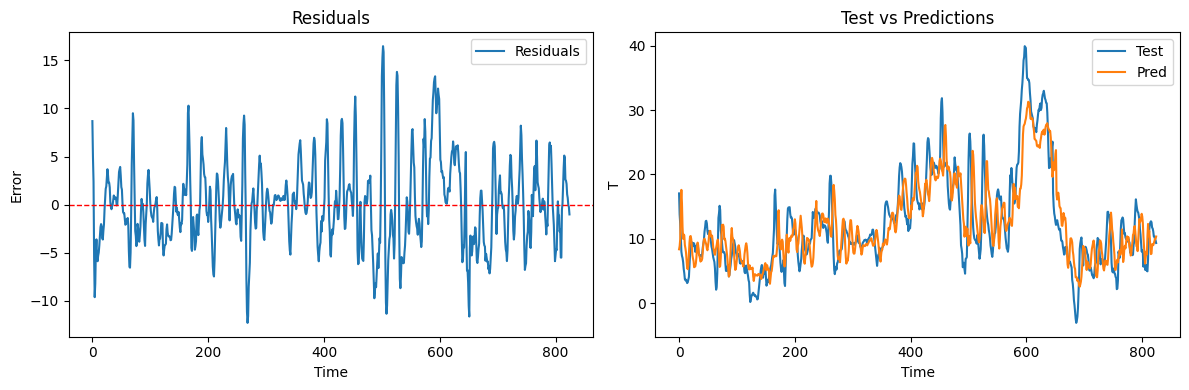


1H series (6 steps-ahead forecasts)
1H Custom RNN: MAE=3.28, RMSE=4.33, MAPE=47.81


In [ ]:
# predict (6-steps ahead with 1H model)

# first create a test dataloader whose targets are the next 6 values per sample
X_h6_test, y_h6_test = create_sequences(hour_test_norm, window_size=hour_window_size, horizon=6)
hour6_test_loader = to_loader(X_h6_test, y_h6_test)
print("Shapes:", X_h6_test.shape, y_h6_test.shape)

crnn_preds1h_6h_last_norm, crnn_trues1h_6h_last_norm, _, _ = predict_custom_rnn(
    hour6_test_loader, history1h_1h['params'], n_steps=6)

# denormalize, plot and evaluate
crnn_preds1h_6h = denormalize(crnn_preds1h_6h_last_norm, hour_train_mean, hour_train_std)
crnn_trues1h_6h = denormalize(crnn_trues1h_6h_last_norm, hour_train_mean, hour_train_std)
plot_residuals_preds(crnn_trues1h_6h, crnn_preds1h_6h)
mae16, rmse16, mape16 = evaluate_model(crnn_trues1h_6h, crnn_preds1h_6h)

print("\n1H series (6 steps-ahead forecasts)")
print(f"1H Custom RNN: MAE={mae16}, RMSE={rmse16}, MAPE={mape16}")

6H resolution model's training (horizon=1)
Epoch 10/100, Train Loss: 0.0912, Train R²: 0.9061 | Val Loss: 0.1989, Val R²: 0.7479
Epoch 20/100, Train Loss: 0.0748, Train R²: 0.9230 | Val Loss: 0.1858, Val R²: 0.7644
Early stopping at epoch 22 (no val loss improvement for 10 epochs).

Total training time: 328.83 seconds
Total trainable parameters: 4289



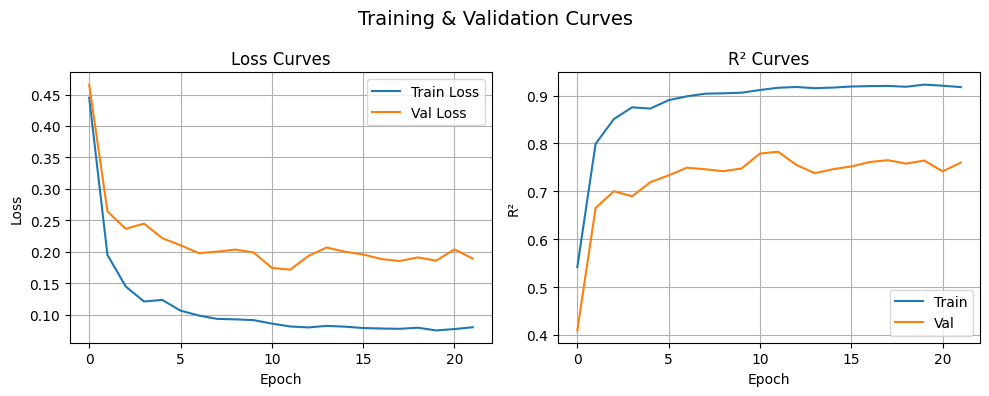

In [ ]:
# 6H custom RNN training (horizon=1)
print("6H resolution model's training (horizon=1)")
history6h_1h = train_custom_rnn(six_train_loader, six_val_loader)

# plot learning curves
plot_history(history6h_1h)

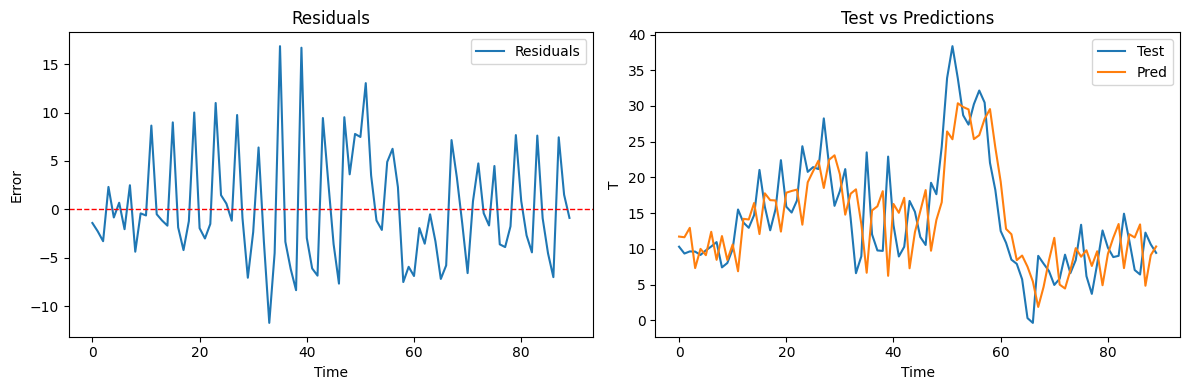


6H series (1 steps-ahead forecasts)
6H Custom RNN Training Time: 328.8347
6H Custom RNN Total Params: 4289
6H Custom RNN: MAE=4.52, RMSE=5.75, MAPE=79.03


In [ ]:
# predict (1-step ahead with 6H model)
crnn_preds6h_1h_last_norm, crnn_trues6h_1h_last_norm, _, _ = predict_custom_rnn(six_test_loader, history6h_1h['params'])

# denormalize, plot and evaluate
crnn_preds6h_1h = denormalize(crnn_preds6h_1h_last_norm, six_train_mean, six_train_std)
crnn_trues6h_1h = denormalize(crnn_trues6h_1h_last_norm, six_train_mean, six_train_std)
plot_residuals_preds(crnn_trues6h_1h, crnn_preds6h_1h)
mae6, rmse6, mape6 = evaluate_model(crnn_trues6h_1h, crnn_preds6h_1h)

print("\n6H series (1 steps-ahead forecasts)")
print("6H Custom RNN Training Time:", history6h_1h['total_training_time'])
print("6H Custom RNN Total Params:", history6h_1h['total_params'])
print(f"6H Custom RNN: MAE={mae6}, RMSE={rmse6}, MAPE={mape6}")

Original length (after NaN filtering): 146
Window size: 56, Horizon: 4, Step: 1
Created samples: 87
X shape: (87, 56, 1)  (features=1)
y shape: (87, 4)
X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X data types: float32, y data types: float32
Feature (+Target): T


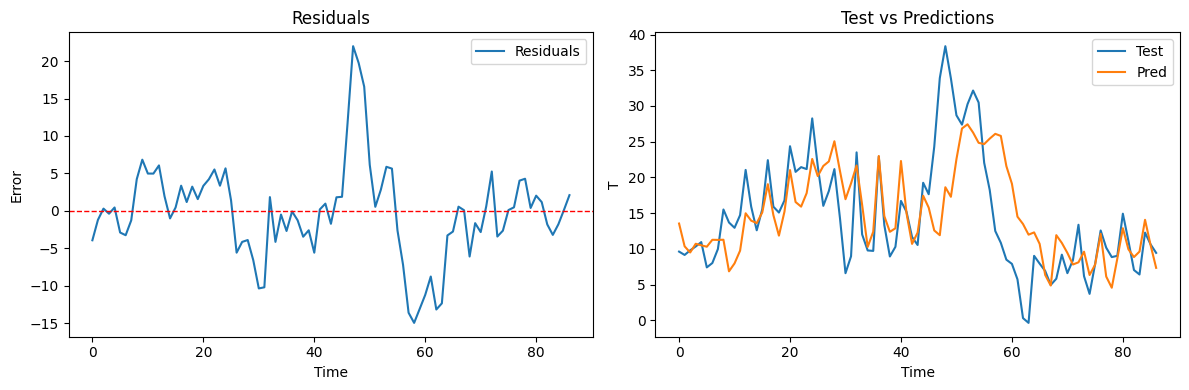


6H series (4 steps-ahead forecasts)
6H Custom RNN: MAE=4.43, RMSE=6.32, MAPE=121.96


In [ ]:
# predict (4-steps ahead with 6H model)

# first create a test dataloader whose targets are the next 6 values per sample
X_64_test, y_64_test = create_sequences(six_test_norm, window_size=six_window_size, horizon=4)
six4_test_loader = to_loader(X_64_test, y_64_test)
# print("Shapes:", X_64_test.shape, y_64_test.shape)

crnn_preds6h_4h_last_norm, crnn_trues6h_4h_last_norm, _, _ = predict_custom_rnn(six4_test_loader, history6h_1h['params'], n_steps=4)

# denormalize, plot and evaluate
crnn_preds6h_4h = denormalize(crnn_preds6h_4h_last_norm, six_train_mean, six_train_std)
crnn_trues6h_4h = denormalize(crnn_trues6h_4h_last_norm, six_train_mean, six_train_std)
plot_residuals_preds(crnn_trues6h_4h, crnn_preds6h_4h)
mae4, rmse4, mape4 = evaluate_model(crnn_trues6h_4h, crnn_preds6h_4h)

print("\n6H series (4 steps-ahead forecasts)")
print(f"6H Custom RNN: MAE={mae4}, RMSE={rmse4}, MAPE={mape4}")

24H resolution model's training (horizon=1)
Epoch 10/100, Train Loss: 0.1184, Train R²: 0.8624 | Val Loss: 0.3989, Val R²: -0.9663
Early stopping at epoch 12 (no val loss improvement for 10 epochs).

Total training time: 21.88 seconds
Total trainable parameters: 4289



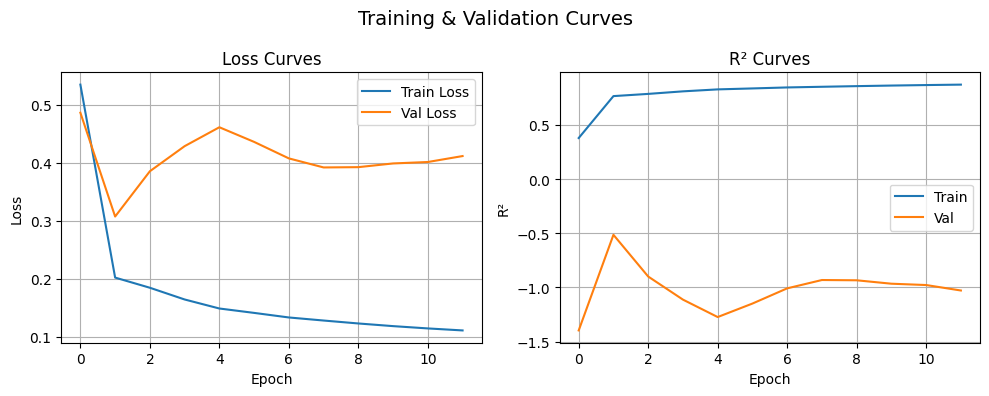

In [ ]:
# 24H custom RNN training (horizon=1)
print("24H resolution model's training (horizon=1)")
history24h_1h = train_custom_rnn(day_train_loader, day_val_loader)

# plot learning curves
plot_history(history24h_1h)

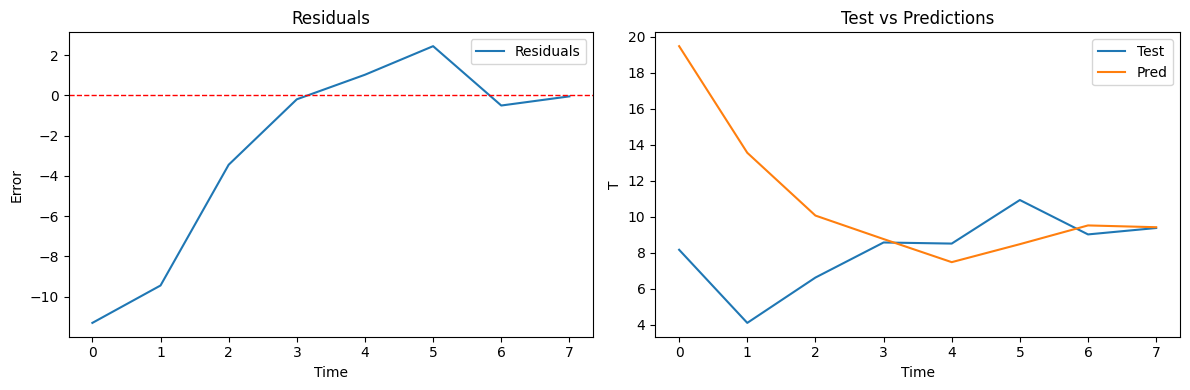


24H series (1 steps-ahead forecasts)
24H Custom RNN Training Time: 21.8756
24H Custom RNN Total Params: 4289
24H Custom RNN: MAE=3.55, RMSE=5.44, MAPE=58.01


In [ ]:
# predict (1-step ahead with 24H model)
crnn_preds24h_1h_last_norm, crnn_trues24h_1h_last_norm, _, _ = predict_custom_rnn(day_test_loader, history24h_1h['params'])

# denormalize, plot and evaluate
crnn_preds24h_1h = denormalize(crnn_preds24h_1h_last_norm, day_train_mean, day_train_std)
crnn_trues24h_1h = denormalize(crnn_trues24h_1h_last_norm, day_train_mean, day_train_std)
plot_residuals_preds(crnn_trues24h_1h, crnn_preds24h_1h)
mae24, rmse24, mape24 = evaluate_model(crnn_trues24h_1h, crnn_preds24h_1h)

print("\n24H series (1 steps-ahead forecasts)")
print("24H Custom RNN Training Time:", history24h_1h['total_training_time'])
print("24H Custom RNN Total Params:", history24h_1h['total_params'])
print(f"24H Custom RNN: MAE={mae24}, RMSE={rmse24}, MAPE={mape24}")

In [ ]:
# store all the results
columns = ["Model", "Resolution", "Horizon", "Target Variable", "Input Type", "MAE", "RMSE", "MAPE (%)", "Fit Time", "# Params"]

rnn_results = [
    ("Custom RNN", "1-hour", "t+1", "T_mean", "Univariate", mae1, rmse1, mape1, history1h_1h['total_training_time'], history1h_1h['total_params']),
    ("Custom RNN", "1-hour", "t+6", "T_mean", "Univariate", mae16, rmse16, mape16, history1h_1h['total_training_time'], history1h_1h['total_params']),
    ("Custom RNN", "6-hour", "t+1", "T_mean", "Univariate", mae6, rmse6, mape6, history6h_1h['total_training_time'], history6h_1h['total_params']),
    ("Custom RNN", "6-hour", "t+4", "T_mean", "Univariate", mae4, rmse4, mape4, history6h_1h['total_training_time'], history6h_1h['total_params']),
    ("Custom RNN", "24-hour", "t+1", "T_mean", "Univariate", mae24, rmse24, mape24, history24h_1h['total_training_time'], history24h_1h['total_params'])
]

In [ ]:
# print rnn results
print(tabulate(rnn_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model      | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom RNN | 1-hour       | t+1       | T_mean            | Univariate   |  0.86 |   1.25 |      11.15 |    1402.05 |       4289 |
| Custom RNN | 1-hour       | t+6       | T_mean            | Univariate   |  3.28 |   4.33 |      47.81 |    1402.05 |       4289 |
| Custom RNN | 6-hour       | t+1       | T_mean            | Univariate   |  4.52 |   5.75 |      79.03 |     328.83 |       4289 |
| Custom RNN | 6-hour       | t+4       | T_mean            | Univariate   |  4.43 |   6.32 |     121.96 |     328.83 |       4289 |
| Custom RNN | 24-hour      | t+1       | T_mean            | Univariate   |  3.55 |   5.44 |      58.01 |      21.88 |       4289 |


### Pytorch RNN

In [ ]:
# grab one batch from a loader
batch = next(iter(hour_train_loader))
X, y = batch

# take first sequence and target
x = X[0]   # shape: (seq_len, input_size) or (seq_len,)
y = y[0]

print("Original x shape:", x.shape)
print("Original y shape:", y.shape)

Original x shape: torch.Size([48, 1])
Original y shape: torch.Size([1])


In [ ]:
# it's of shape (seq_len, input_size) -> we need to add batch dimension to make it suitable for RNN
x = x.unsqueeze(-1) # (seq_len, batch=1, input_size=1)
print("x reshaped for RNN:", x.shape)

x reshaped for RNN: torch.Size([48, 1, 1])


In [ ]:
# define a simple RNN
input_size = x.shape[-1] # here is 1 (temperature)
hidden_size = 4 # hidden dimension
rnn = nn.RNN(input_size, hidden_size, batch_first=False)

# forward pass
output, hidden = rnn(x)

In [ ]:
print("RNN outputs")
print("output of all hidden states for all timesteps of sequence length:", output.shape, "(sequence of context vectors, one per timestep)")
print("hidden (last hidden state):", hidden.shape, "(final context vector summarizing the sequence)")
print("\nExample:")
print("At time t, output[t] is the hidden state after t steps:", output[0].shape)
print("Final hidden state (same as last output row):", hidden[-1].shape)

RNN outputs
output of all hidden states for all timesteps of sequence length: torch.Size([48, 1, 4]) (sequence of context vectors, one per timestep)
hidden (last hidden state): torch.Size([1, 1, 4]) (final context vector summarizing the sequence)

Example:
At time t, output[t] is the hidden state after t steps: torch.Size([1, 4])
Final hidden state (same as last output row): torch.Size([1, 4])


As we saw earlier in the custom RNN, for each timestep of a sample (e.g. for each of 48 values), the input scalar is transformed into a hidden state across several units (here 4). Each timestep therefore produces a hidden state of shape (1, 4), and stacking them gives an output of shape (48, 1, 4). The final hidden state (1, 1, 4) can be viewed as the overall context vector summarizing the entire sequence. Let's now apply the modular PyTorch version of the above custom RNN to see the same process using built-in layers.

In [ ]:
# modular RNN
class mod_rnn(nn.Module):
  """
  Class for a simple modular RNN model.
  """
  def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, num_layers=1):
    super(mod_rnn, self).__init__()

    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h, _ = self.rnn(x)
    # print(h.shape)
    last_h_t = h[:, -1, :] # take the output from the last time step
    out = self.fc(last_h_t)
    return out

def train_mod_rnn(train_loader, val_loader, model_type='rnn', epochs=100, lr=1e-3, optimizer=torch.optim.Adam, verbose_every=10, patience=10):
  """
  Trains a PyTorch RNN model using the standard architecture:
    the hidden state at each time step depends on the current input and the previous hidden state (not the previous output). This architecture is suitable for sequence-to-sequence prediction, such as multivariate weather forecasting.

  Args:
    - X (torch.Tensor): Input tensor of shape (num_samples, sequence_length, input_dim), containing past observations (e.g., weather
    - y (torch.Tensor): Target tensor of shape (num_samples, sequence_length, output_dim), containing the expected output at each time step
    - model_type (str): Type of RNN model to use ('rnn' or 'lstm')
    - epochs (int): Number of training epochs
    - lr (float): Learning rate used by the optimizer
    - optimizer: PyTorch optimizer class to use (default: torch.optim.Adam)
    - verbose_every (int): Print loss every N epochs

  Returns:
    - model (torch.nn.Module): Trained RNN model
    - history (dict): Dictionary containing training history with loss and r2 score
    - total_training_time (float): Total training time in seconds
    - total_params (int): Total number of trainable parameters in the model
  """
  # use gpu, if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # instantiate the model
  if model_type == 'rnn':
    rnn_model = mod_rnn(input_dim=1, hidden_dim=64, output_dim=1, num_layers=1).to(device)
  elif model_type == 'lstm':
    rnn_model = mod_lstm(input_dim=1, hidden_dim=64, output_dim=1, num_layers=1).to(device)
  else:
    raise ValueError("Invalid model type. Must be 'rnn' or 'lstm'.")

  # set optimizer and loss function
  optimizer = optimizer(rnn_model.parameters(), lr=lr, weight_decay=1e-4)
  loss_fn = nn.MSELoss()

  # initialaize history dict
  history = {"train_loss": [], "train_r2": [], "val_loss": [], "val_r2": []}

  # early stopping state
  best_val_loss = float('inf')
  best_state = None
  epochs_no_improve = 0

  # training loop
  start_time = time.time()
  for epoch in range(1, epochs + 1):

    # train step
    rnn_model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = [] # collect y for R²

    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      if y_batch.ndim == 1:  # ensure (B,1)
        y_batch = y_batch.view(-1, 1)

      # forward pass
      preds = rnn_model(X_batch)
      # print(preds.shape)  # (batch_size, 1)

      # compute loss
      loss = loss_fn(preds, y_batch)  # mean loss over all elements in the batch, not per sample

      # backprop
      optimizer.zero_grad()
      loss.backward()
      # add gradient clipping to prevent exploding gradients during backpropagation
      torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), max_norm=5.0)
      optimizer.step()

      # update total loss
      train_loss += loss.item() * X_batch.size(0)  # weight by batch size

      train_preds.append(preds.detach())
      train_targets.append(y_batch.detach())

    # average over number of samples seen
    num_train_seen = sum(b[0].size(0) for b in train_loader)
    train_loss /= max(1, num_train_seen)
    train_preds = torch.cat(train_preds, dim=0).squeeze() # flatten list of batch predictions into a single tensor of shape (N,)
    train_targets = torch.cat(train_targets, dim=0).squeeze()
    train_r2 = r2_fn(train_targets.cpu(), train_preds.cpu())

    # validation step
    rnn_model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        if y_batch.ndim == 1: # ensure (B,1)
           y_batch = y_batch.view(-1, 1)

        # forward pass
        preds = rnn_model(X_batch)

        # compute loss
        loss = loss_fn(preds, y_batch)
        val_loss += loss.item() * X_batch.size(0)  # weight by batch size

        val_preds.append(preds.detach())
        val_targets.append(y_batch.detach())

    num_val_seen = sum(b[0].size(0) for b in val_loader)
    val_loss /= max(1, num_val_seen)
    val_preds = torch.cat(val_preds, dim=0).squeeze() # flatten list of batch predictions into a single tensor of shape (N,)
    val_targets = torch.cat(val_targets, dim=0).squeeze()
    val_r2 = r2_fn(val_targets.cpu(), val_preds.cpu())

    # store the metrics
    history["train_loss"].append(train_loss)
    history["train_r2"].append(train_r2)
    history["val_loss"].append(val_loss)
    history["val_r2"].append(val_r2)

    # print every_verbose epoch's progress
    if (epoch+1) % verbose_every == 0:
      print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train R²: {train_r2:.4f} | Val Loss: {val_loss:.4f} | Val R²: {val_r2:.4f}")

    # early stopping on val loss
    if val_loss + 1e-8 < best_val_loss:
      best_val_loss = val_loss
      best_state = {k: v.detach().cpu().clone() for k, v in rnn_model.state_dict().items()}
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} (no val loss improvement for {patience} epochs).")
        break

  end_time = time.time()
  total_training_time = end_time - start_time
  print(f"\nTotal training time: {total_training_time:.2f} seconds")

  # count total trainable params
  params = list(rnn_model.parameters())
  total_params = count_trainable_params(params)
  print(f"Total trainable parameters: {total_params}\n")

  # load best weights before returning
  if best_state is not None:
    rnn_model.load_state_dict(best_state)

  # add extras into history
  history.update({
      "model": rnn_model,
      "total_training_time": round(total_training_time, 4),
      "total_params": total_params,
      "best_val_loss": float(best_val_loss),
      "stopped_epoch": epoch
  })

  return history

In [ ]:
# training with modular RNN
print("1H resolution model's training")
mod_hour_history_rnn = train_mod_rnn(hour_train_loader, hour_val_loader)

print("6H resolution model's training")
mod_six_hour_history_rnn = train_mod_rnn(six_train_loader, six_val_loader)

print("24H resolution model's training")
mod_daily_history_rnn = train_mod_rnn(day_train_loader, day_val_loader,)

1H resolution model's training
Epoch 10/100 | Train Loss: 0.0098 | Train R²: 0.9901 | Val Loss: 0.0218 | Val R²: 0.9777
Epoch 20/100 | Train Loss: 0.0085 | Train R²: 0.9914 | Val Loss: 0.0158 | Val R²: 0.9838
Epoch 30/100 | Train Loss: 0.0087 | Train R²: 0.9911 | Val Loss: 0.0158 | Val R²: 0.9839
Early stopping at epoch 34 (no val loss improvement for 10 epochs).

Total training time: 22.25 seconds
Total trainable parameters: 4353

6H resolution model's training
Epoch 10/100 | Train Loss: 0.1021 | Train R²: 0.8948 | Val Loss: 0.2301 | Val R²: 0.7083
Epoch 20/100 | Train Loss: 0.0857 | Train R²: 0.9117 | Val Loss: 0.2168 | Val R²: 0.7251
Epoch 30/100 | Train Loss: 0.0816 | Train R²: 0.9160 | Val Loss: 0.2009 | Val R²: 0.7453
Early stopping at epoch 33 (no val loss improvement for 10 epochs).

Total training time: 3.52 seconds
Total trainable parameters: 4353

24H resolution model's training
Epoch 10/100 | Train Loss: 0.1968 | Train R²: 0.7712 | Val Loss: 0.4186 | Val R²: -1.0632
Epoch 2

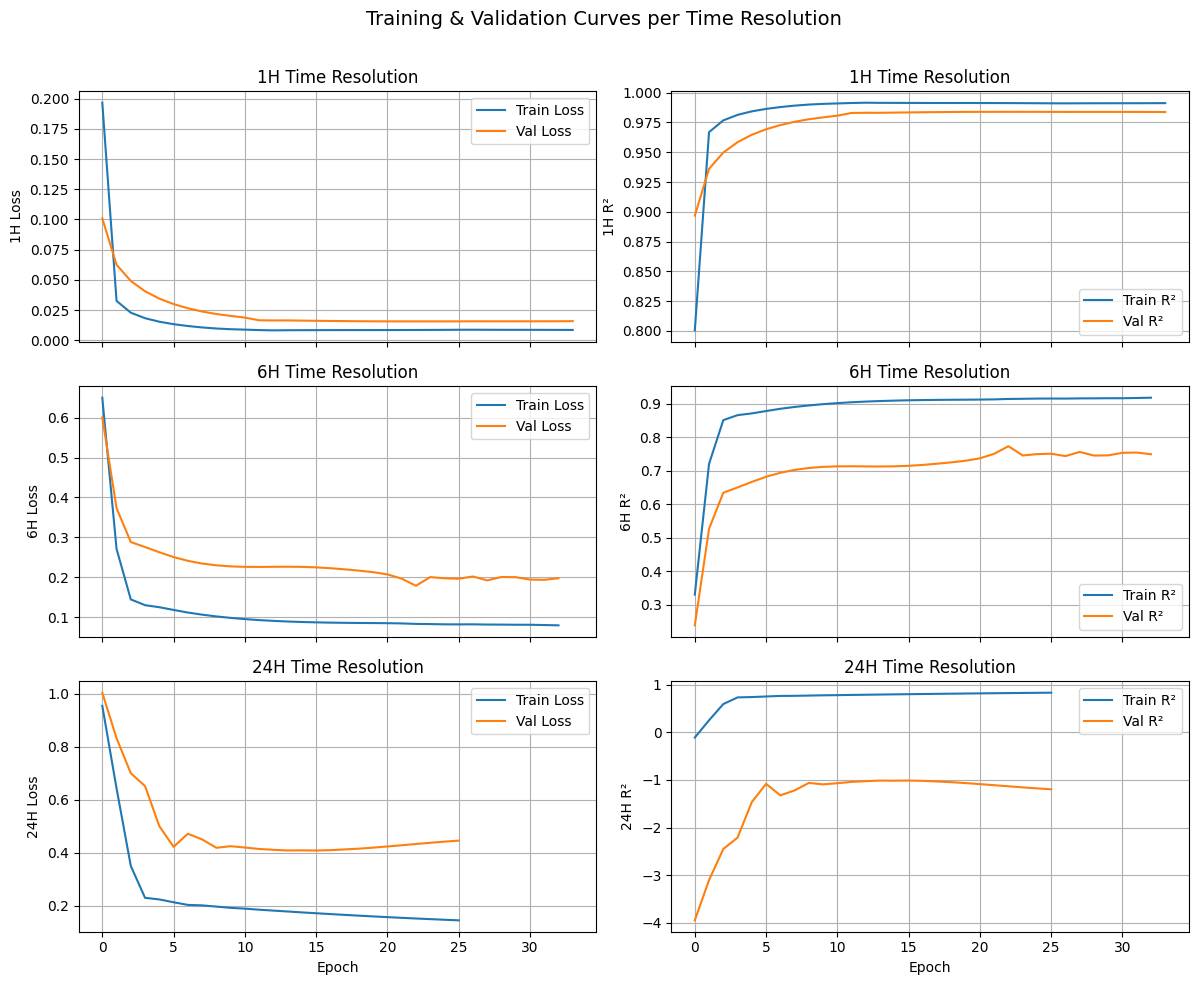

In [ ]:
# plot all learning curves at once
plot_learning_curves_all([mod_hour_history_rnn, mod_six_hour_history_rnn, mod_daily_history_rnn], ["1H", "6H", "24H"])

In [ ]:
@torch.no_grad()
def predict_mod_rnn_single(model, X_seq, n_steps=1):
  """
  Predicts t+n_steps for ONE sequence.

  Args:
     model: trained mod_rnn (outputs shape (B,1))
     X_seq: torch.Tensor, shape (L,1) or (L,)  — normalized window
     n_steps: int, horizon (e.g., 1 or 6)

  Returns:
     float: last-step prediction (t+n_steps)
  """
  model.eval()
  device = next(model.parameters()).device

  # ensure shape (1, L, 1)
  if X_seq.dim() == 1: # (L,) -> (L,1)
    X_seq = X_seq.unsqueeze(-1)
  X_seq = X_seq.unsqueeze(0).to(device).float()  # (1,L,1)

  last_pred = None
  for _ in range(n_steps):
    pred = model(X_seq) # (1,1)
    last_pred = float(pred.squeeze().item()) # scalar
    next_input = pred.unsqueeze(1) # (1,1,1)
    # slide window forward by 1 and append prediction
    X_seq = torch.cat([X_seq[:, 1:], next_input], dim=1) # (1,L,1)

  return last_pred


@torch.no_grad()
def predict_mod_rnn(model, loader, n_steps=1):
  """
  Predicts t+n_steps for ALL samples in a DataLoader.

  Args:
     model: trained mod_rnn
     loader: yields (Xb, yb) where Xb=(B,L,1), yb=(B,) or (B,H)  — normalized
     n_steps: int, horizon for rollout

  Returns:
     preds_last: np.ndarray (N,) — last-step predictions
     trues_last: np.ndarray (N,) — last-step ground truths (from labels’ last column)
  """
  model.eval()
  device = next(model.parameters()).device

  preds_last, trues_last = [], []

  for batch in loader:
    if isinstance(batch, (list, tuple)) and len(batch) == 2:  # (Xb, yb) or Xb-only
      Xb, yb = batch
      yb = yb.to(device)
    else:
      Xb, yb = batch, None

    Xb = Xb.to(device)  # Xb: (B,L,1)
    B = Xb.size(0)

    for i in range(B):
      # single-sequence prediction -> last-step float
      y_hat_last = predict_mod_rnn_single(model, Xb[i].squeeze(0), n_steps=n_steps)
      preds_last.append(float(y_hat_last))

      # last-step truth: take last element along horizon dim
      if yb is not None:
        yi = yb[i].view(-1)  # (1,) or (H,)
        trues_last.append(float(yi[-1].item()))

  preds_last = np.asarray(preds_last, dtype=float)
  trues_last = np.asarray(trues_last, dtype=float) if trues_last else None
  return preds_last, trues_last

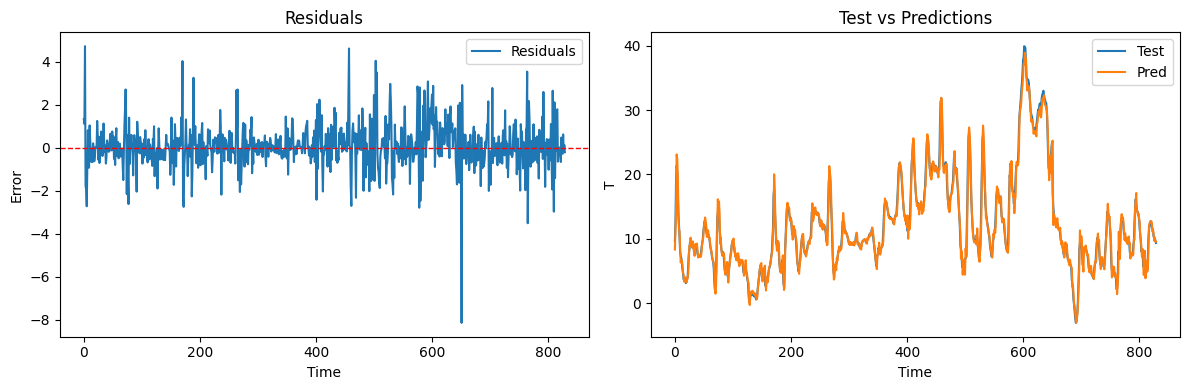

1H model Training Time: 22.2529
1H model Total Params: 4353
1H model (1-step): MAE=0.70, RMSE=1.03, MAPE=8.36


In [ ]:
# 1H model: 1-step ahead
hour_preds_mod_rnn, hour_trues_mod_rnn = predict_mod_rnn(mod_hour_history_rnn['model'], hour_test_loader)

# denormalize, plot and evaluate
hour_preds_mod_rnn = denormalize(hour_preds_mod_rnn, hour_train_mean, hour_train_std)
hour_trues_mod_rnn = denormalize(hour_trues_mod_rnn, hour_train_mean, hour_train_std)
plot_residuals_preds(hour_trues_mod_rnn, hour_preds_mod_rnn, "1H")
mae_h1_1, rmse_h1_1, mape_h1_1 = evaluate_model(hour_trues_mod_rnn, hour_preds_mod_rnn)

print(f"1H model Training Time: {mod_hour_history_rnn['total_training_time']}")
print(f"1H model Total Params: {mod_hour_history_rnn['total_params']}")
print(f"1H model (1-step): MAE={mae_h1_1}, RMSE={rmse_h1_1}, MAPE={mape_h1_1}")

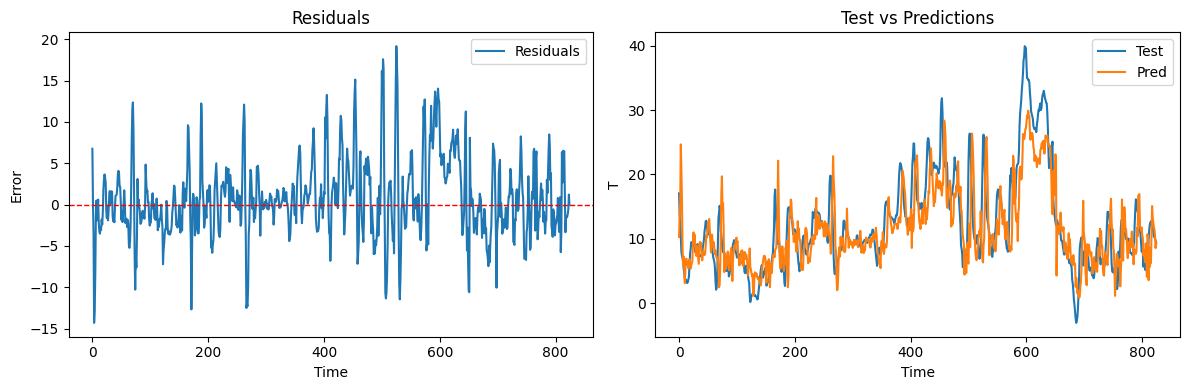

1H model (6-step): MAE=3.42, RMSE=4.73, MAPE=45.61


In [ ]:
# 1H model: 6-step ahead
hour6_preds_mod_rnn, hour6_trues_mod_rnn = predict_mod_rnn(mod_hour_history_rnn['model'], hour6_test_loader, n_steps=6)

# denormalize, plot and evaluate
hour6_preds_mod_rnn = denormalize(hour6_preds_mod_rnn, hour_train_mean, hour_train_std)
hour6_trues_mod_rnn = denormalize(hour6_trues_mod_rnn, hour_train_mean, hour_train_std)
plot_residuals_preds(hour6_trues_mod_rnn, hour6_preds_mod_rnn, "1H")
mae_h1_6, rmse_h1_6, mape_h1_6 = evaluate_model(hour6_trues_mod_rnn, hour6_preds_mod_rnn)

print(f"1H model (6-step): MAE={mae_h1_6}, RMSE={rmse_h1_6}, MAPE={mape_h1_6}")

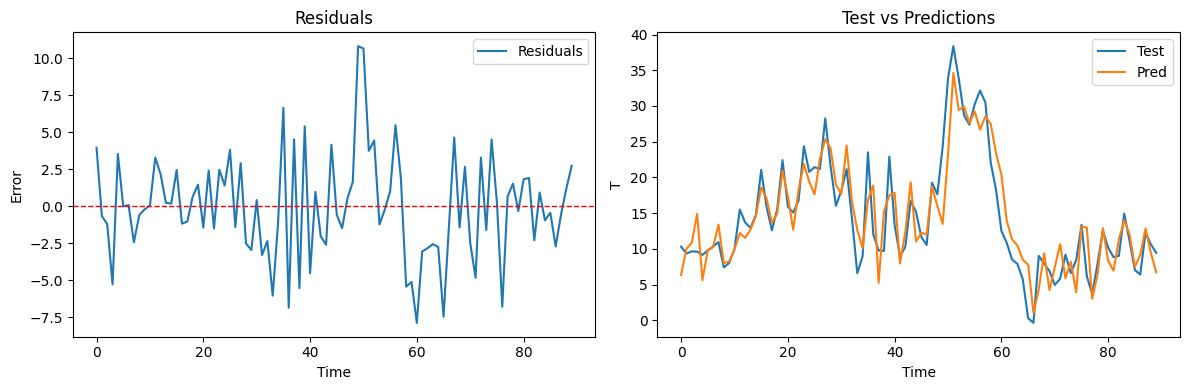

6H model Training Time: 3.5249
6H model Total Params: 4353
6H model (1-step): MAE=2.70, RMSE=3.52, MAPE=54.07


In [ ]:
# 6H model: 1-step ahead
six_hour_preds_mod_rnn, six_hour_trues_mod_rnn = predict_mod_rnn(mod_six_hour_history_rnn['model'], six_test_loader)

# denormalize, plot and evaluate
six_hour_preds_mod_rnn = denormalize(six_hour_preds_mod_rnn, six_train_mean, six_train_std)
six_hour_trues_mod_rnn = denormalize(six_hour_trues_mod_rnn, six_train_mean, six_train_std)
plot_residuals_preds(six_hour_trues_mod_rnn, six_hour_preds_mod_rnn, "6H")
mae_6h_1, rmse_6h_1, mape_6h_1 = evaluate_model(six_hour_trues_mod_rnn, six_hour_preds_mod_rnn)

print(f"6H model Training Time: {mod_six_hour_history_rnn['total_training_time']}")
print(f"6H model Total Params: {mod_six_hour_history_rnn['total_params']}")
print(f"6H model (1-step): MAE={mae_6h_1}, RMSE={rmse_6h_1}, MAPE={mape_6h_1}")

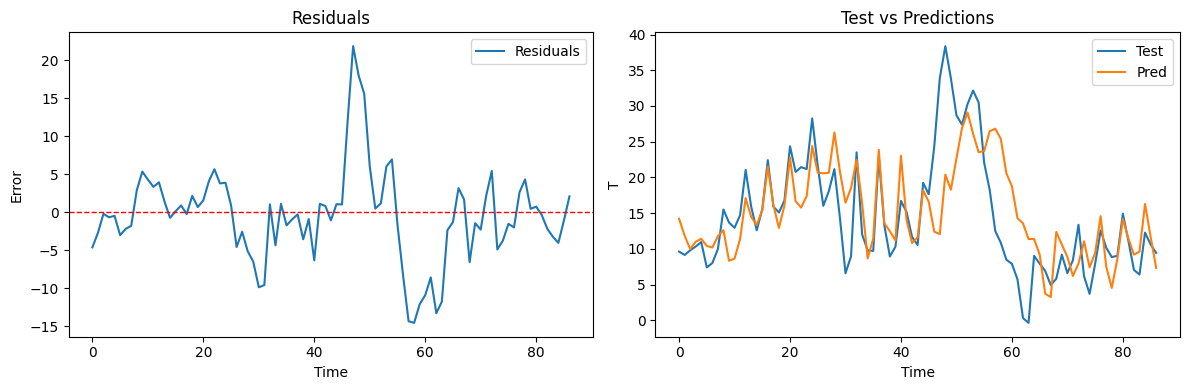

6H model (4-step): MAE=4.23, RMSE=6.11, MAPE=120.28


In [ ]:
# 6H model: 4-step ahead
six4_preds_mod_rnn, six4_trues_mod_rnn = predict_mod_rnn(mod_six_hour_history_rnn['model'], six4_test_loader, n_steps=4)

# denormalize, plot and evaluate
six4_preds_mod_rnn = denormalize(six4_preds_mod_rnn, six_train_mean, six_train_std)
six4_trues_mod_rnn = denormalize(six4_trues_mod_rnn, six_train_mean, six_train_std)
plot_residuals_preds(six4_trues_mod_rnn, six4_preds_mod_rnn, "6H")
mae_6h_4, rmse_6h_4, mape_6h_4 = evaluate_model(six4_trues_mod_rnn, six4_preds_mod_rnn)

print(f"6H model (4-step): MAE={mae_6h_4}, RMSE={rmse_6h_4}, MAPE={mape_6h_4}")

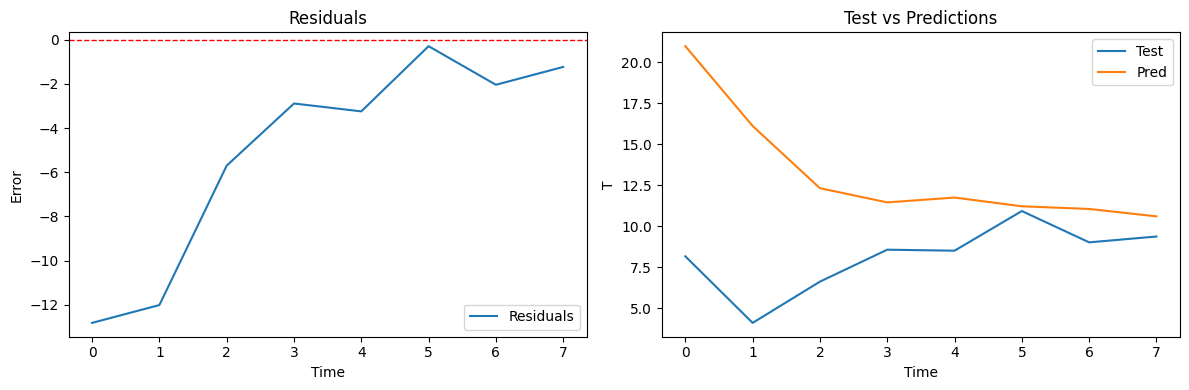

24H model Training Time: 0.7047
24H model Total Params: 4353
24H model (1-step): MAE=5.03, RMSE=6.76, MAPE=80.85


In [ ]:
# 24H model: 1-step
daily_preds_mod_rnn, daily_trues_mod_rnn = predict_mod_rnn(mod_daily_history_rnn['model'], day_test_loader)

# denormalize, plot and evaluate
daily_preds_mod_rnn = denormalize(daily_preds_mod_rnn, day_train_mean, day_train_std)
daily_trues_mod_rnn = denormalize(daily_trues_mod_rnn, day_train_mean, day_train_std)
plot_residuals_preds(daily_trues_mod_rnn, daily_preds_mod_rnn, "24H")
mae_24h_1, rmse_24h_1, mape_24h_1 = evaluate_model(daily_trues_mod_rnn, daily_preds_mod_rnn)

print(f"24H model Training Time: {mod_daily_history_rnn['total_training_time']}")
print(f"24H model Total Params: {mod_daily_history_rnn['total_params']}")
print(f"24H model (1-step): MAE={mae_24h_1}, RMSE={rmse_24h_1}, MAPE={mape_24h_1}")

In [ ]:
# collect evaluation results for modular rnn results for all time resolutions
rnn_results += ([
    ("Modular RNN", "1-hour", "t+1", "T_mean", "Univariate", mae_h1_1, rmse_h1_1, mape_h1_1, mod_hour_history_rnn['total_training_time'], mod_hour_history_rnn['total_params']),
    ("Modular RNN", "1-hour", "t+6", "T_mean", "Univariate", mae_h1_6, rmse_h1_6, mape_h1_6, mod_six_hour_history_rnn['total_training_time'], mod_six_hour_history_rnn['total_params']),
    ("Modular RNN", "6-hour", "t+1", "T_mean", "Univariate", mae_6h_1, rmse_6h_1, mape_6h_1, mod_six_hour_history_rnn['total_training_time'], mod_six_hour_history_rnn['total_params']),
    ("Modular RNN", "6-hour", "t+4", "T_mean", "Univariate", mae_6h_4, rmse_6h_4, mape_6h_4, mod_six_hour_history_rnn['total_training_time'], mod_six_hour_history_rnn['total_params']),
    ("Modular RNN", "24-hour", "t+1", "T_mean", "Univariate", mae_24h_1, rmse_24h_1, mape_24h_1, mod_daily_history_rnn['total_training_time'], mod_daily_history_rnn['total_params'])
])

In [ ]:
# print results
print(tabulate(rnn_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model       | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|-------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom RNN  | 1-hour       | t+1       | T_mean            | Univariate   |  0.86 |   1.25 |      11.15 |    1402.05 |       4289 |
| Custom RNN  | 1-hour       | t+6       | T_mean            | Univariate   |  3.28 |   4.33 |      47.81 |    1402.05 |       4289 |
| Custom RNN  | 6-hour       | t+1       | T_mean            | Univariate   |  4.52 |   5.75 |      79.03 |     328.83 |       4289 |
| Custom RNN  | 6-hour       | t+4       | T_mean            | Univariate   |  4.43 |   6.32 |     121.96 |     328.83 |       4289 |
| Custom RNN  | 24-hour      | t+1       | T_mean            | Univariate   |  3.55 |   5.44 |      58.01 |      21.88 |       4289 |
| Modular RNN | 1-hour       | t+1       | T_mean            |

## LSTMs

### Custom LSTM

Gated Memory Unit with Prediction Output at Every Time Step.




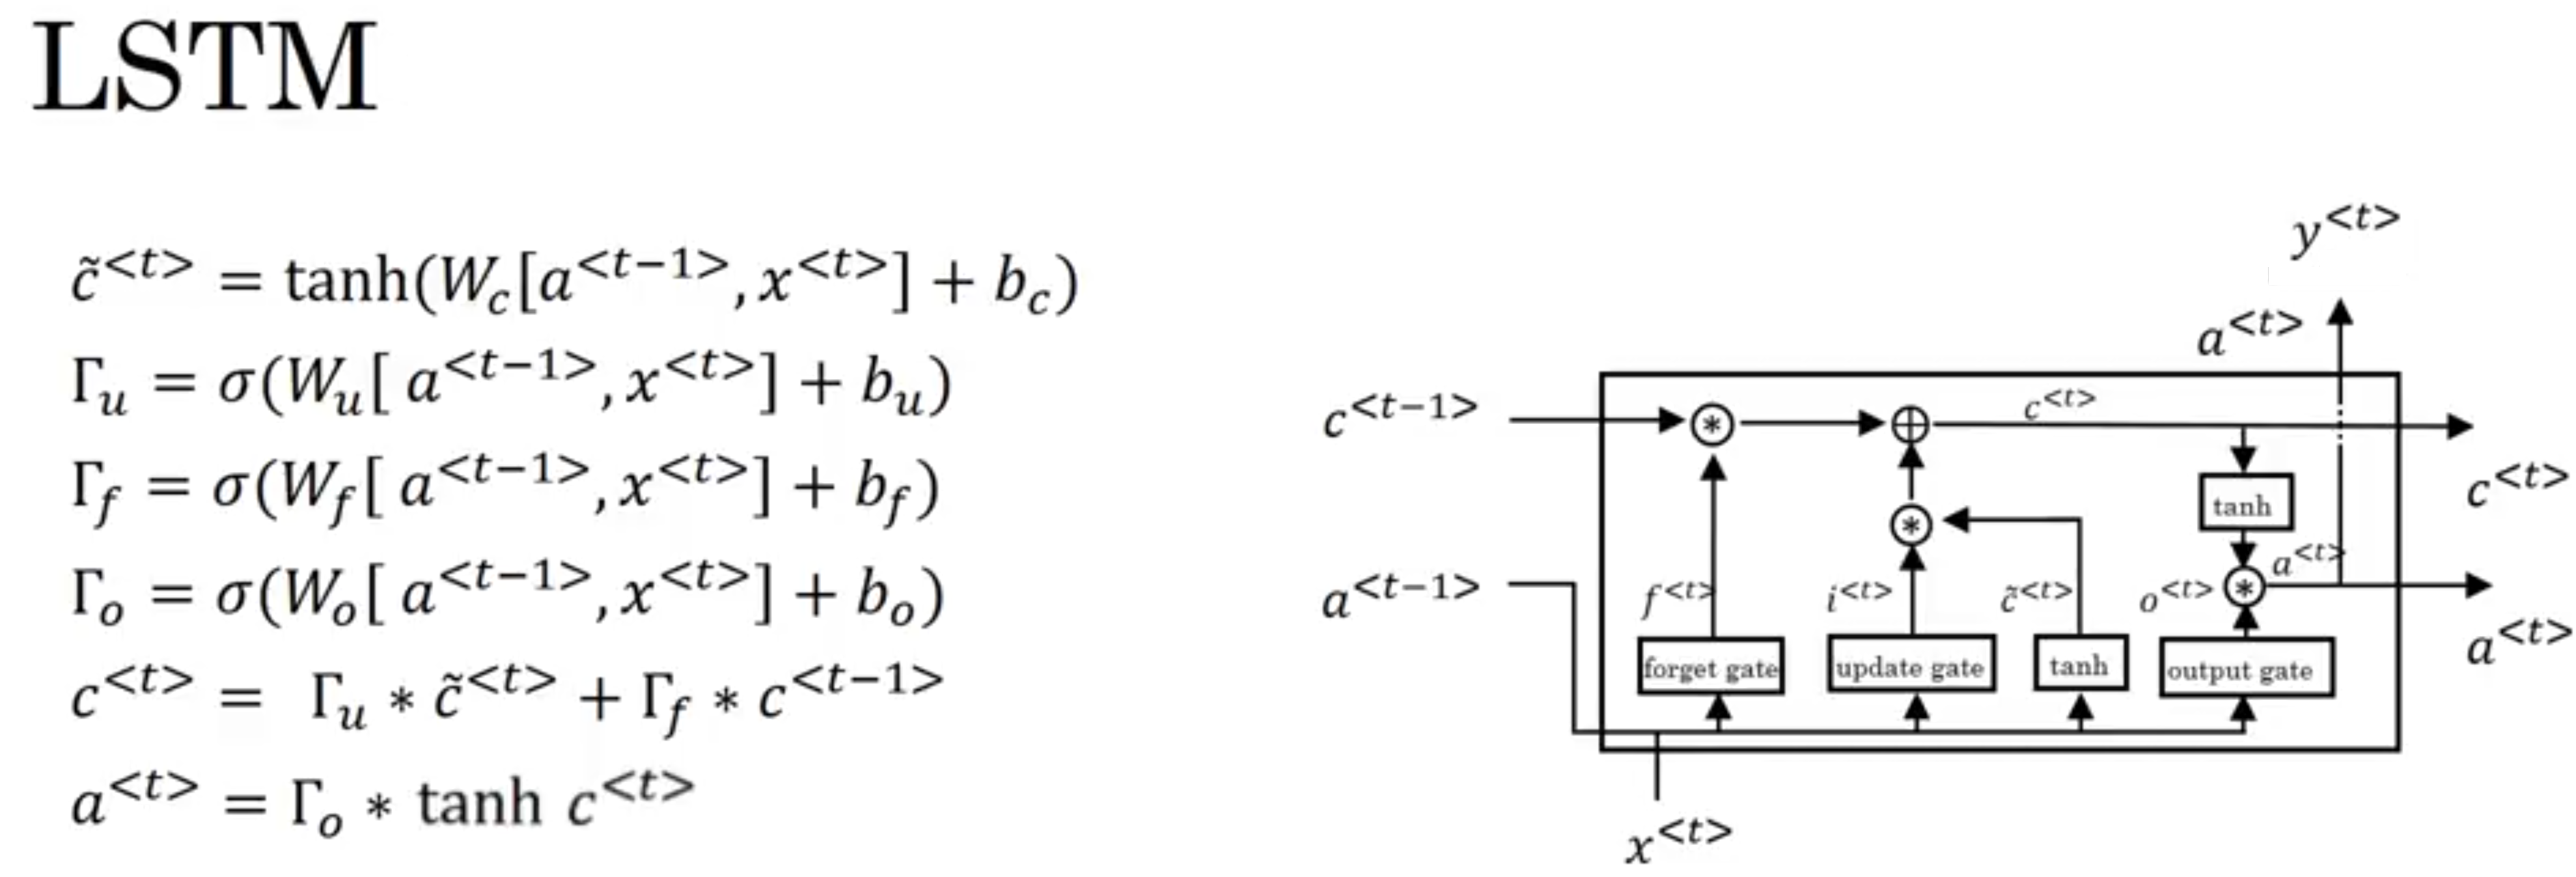

In [ ]:
def train_custom_lstm(train_loader, val_loader, input_size=1, hidden_size=64, output_size=1,
                      epochs=100, lr=1e-3, verbose_every=10, patience=10, weight_decay=1e-4):
  """
  Trains a manual LSTM in batches using matrix equations from the standard LSTM diagram.

  Equations used:
      ĉ_t = tanh(W_c [a_{t-1}, x_t] + b_c)  # current hidden state
      u_t = σ(W_u [a_{t-1}, x_t] + b_u) # update gate
      f_t = σ(W_f [a_{t-1}, x_t] + b_f) # forget gate
      o_t = σ(W_o [a_{t-1}, x_t] + b_o) # outpute gate
      c_t = f_t * c_{t-1} + u_t * ĉ_t # current cell state considering memory from previous time step
      a_t = o_t * tanh(c_t) # current hidden state considering current memory's state c_t (updated or not)
      y_pred = V * a_t + c # current prediction

  Args:
      - X_tensor: torch.Tensor of shape (N, L, 1), input sequences
      - y_tensor: torch.Tensor of shape (N,), target values
      - input_size: number of input features per time step (1 for univariate)
      - hidden_size: size of hidden state units
      - output_size: output size (1 for univariate regression)
      - epochs: int, number of training epochs
      - lr: float, learning rate
      - verbose_every: int, print progress every n epochs

  Returns:
      - params: list of learned parameters
      - history: training + validation losses and R² per epoch
      - total_training_time: total training time in seconds
      - total_params: total number of parameters in the model
  """
  # use gpu, if available
  device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # suppose we have X dataset of shape (7003, 24). Each sample is a vector of (24,). At each time step, X[i][t] is a scalar. To be able to make matrix multiplications, we add a dimsenion (unsqueeze(-1)), so X[i][t] = x_t is of (input_size=1, 1) and a_t is of (hidden_size=32, 1), so total input shape to gates would be (input_size+hidden_size=33, 1)
  concat_size = input_size + hidden_size
  # print(concat_size")

  # initialize weight matrices
  W_u = nn.Parameter(torch.randn(hidden_size, concat_size).to(device)) # (hidden_size, hidden_size+1)
  W_f = nn.Parameter(torch.randn(hidden_size, concat_size).to(device)) # (hidden_size, hidden_size+1)
  W_o = nn.Parameter(torch.randn(hidden_size, concat_size).to(device)) # (hidden_size, hidden_size+1)
  W_c = nn.Parameter(torch.randn(hidden_size, concat_size).to(device)) # (hidden_size, hidden_size+1)

  b_u = nn.Parameter(torch.zeros(hidden_size, 1).to(device))
  b_f = nn.Parameter(torch.zeros(hidden_size, 1).to(device))
  b_o = nn.Parameter(torch.zeros(hidden_size, 1).to(device))
  b_c = nn.Parameter(torch.zeros(hidden_size, 1).to(device))

  V = nn.Parameter(torch.randn(output_size, hidden_size).to(device))
  c_out = nn.Parameter(torch.zeros(output_size, 1).to(device))  # scalar bias for output of (1, 1)

  # apply weight initialization
  nn.init.xavier_uniform_(W_u)
  nn.init.xavier_uniform_(W_f)
  nn.init.xavier_uniform_(W_o)
  nn.init.xavier_uniform_(W_c)
  nn.init.xavier_uniform_(V)

  params = [W_f, W_u, W_c, W_o, b_f, b_u, b_c, b_o, V, c_out]

  # set optimizer and loss function
  optimizer = torch.optim.Adam(params, lr=lr, weight_decay=1e-4)
  loss_fn = nn.MSELoss()

  history = { 'train_loss': [], 'val_loss': [], 'train_r2': [], 'val_r2': [] }

  # simple early stopping on val loss
  best_val_loss = float('inf')
  best_state = [p.detach().clone() for p in params] # initial best params
  best_epoch = 0
  epochs_no_improve = 0

  # train step
  start_time = time.time()
  for epoch in range(epochs):
    total_loss = 0.0
    train_preds, train_targets = [], []

    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      batch_losses = []
      for i in range(X_batch.shape[0]):
        x_seq = X_batch[i]  # (L, 1)
        y_t = y_batch[i].reshape(-1)  # scalar (1,)

        # initialize hidden state h_t and memory c_t
        h_t = torch.zeros((hidden_size, 1), device=device)
        c_t = torch.zeros((hidden_size, 1), device=device)

        # compute h_t and c_t
        for t in range(x_seq.shape[0]):
          x_t = x_seq[t].unsqueeze(-1)  # (1,) -> (1, 1)
          concat = torch.cat((h_t, x_t), dim=0)  # (hidden + input(=1), 1), e.g. (33, 1), this includes a(t-1): h_t == a^{(t-1)}

          c_hat_t = torch.tanh(W_c @ concat + b_c) # (hidden_size, hidden_size+1) @ (hidden_size+1, 1) + (hidden_size, 1) -> (hidden_size, 1)
          u_t = torch.sigmoid(W_u @ concat + b_u) # same -> (hidden_size, 1)
          f_t = torch.sigmoid(W_f @ concat + b_f) # same -> (hidden_size, 1)
          o_t = torch.sigmoid(W_o @ concat + b_o) # same -> (hidden_size, 1)
          c_t = f_t * c_t + u_t * c_hat_t # (hidden_size, 1)
          a_t = o_t * torch.tanh(c_t) # (hidden_size, 1)
          h_t = a_t  # update hidden state for next time step

        # make prediction
        y_pred = V @ a_t + c_out  # (1, hidden_size) * (hidden_size, 1) = (1, 1)
        batch_losses.append(loss_fn(y_pred.reshape(-1), y_t)) # squeeze to (1, 1) -> (1,)

        # (collect for R²)
        train_preds.append(float(y_pred.detach().view(-1).item()))
        train_targets.append(float(y_t.detach().view(-1).item()))

      # backprop once per batch
      loss = torch.stack(batch_losses).mean()
      optimizer.zero_grad()
      loss.backward()
      # add gradient clipping to prevent exploding gradients during backpropagation
      torch.nn.utils.clip_grad_norm_(params, max_norm=5.0)
      optimizer.step()

      total_loss += loss.item() # already a mean over this batch

    avg_train_loss = total_loss / len(train_loader)
    train_r2 = r2_fn(train_targets, train_preds)

    # validation step
    val_preds, val_targets = [], []
    val_loss = 0.0
    with torch.no_grad():
      for X_batch, y_batch in val_loader:
        batch_loss = 0.0
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        for i in range(X_batch.shape[0]):
          x_seq = X_batch[i]
          y_t = y_batch[i].reshape(-1)

          h_t = torch.zeros((hidden_size, 1), device=device)
          c_t = torch.zeros((hidden_size, 1), device=device)

          for t in range(x_seq.shape[0]):
            x_t = x_seq[t].unsqueeze(-1)
            concat = torch.cat((h_t, x_t), dim=0)

            c_hat_t = torch.tanh(W_c @ concat + b_c)
            u_t = torch.sigmoid(W_u @ concat + b_u)
            f_t = torch.sigmoid(W_f @ concat + b_f)
            o_t = torch.sigmoid(W_o @ concat + b_o)
            c_t = f_t * c_t + u_t * c_hat_t
            a_t = o_t * torch.tanh(c_t)
            h_t = a_t  # update hidden state for next time step

          y_pred = V @ a_t + c_out

          batch_loss += loss_fn(y_pred.reshape(-1), y_t).item()

          val_preds.append(float(y_pred.detach().view(-1).item()))
          val_targets.append(float(y_t.detach().view(-1).item()))

        val_loss += batch_loss / X_batch.shape[0]

    avg_val_loss = val_loss / len(val_loader)
    val_r2 = r2_fn(val_targets, val_preds)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)

    if (epoch + 1) % verbose_every == 0:
      print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train R²: {train_r2:.4f} | Val Loss: {avg_val_loss:.4f}, Val R²: {val_r2:.4f}")

    # early stopping update
    if avg_val_loss + 1e-8 < best_val_loss:
      best_val_loss = avg_val_loss
      best_state = [p.detach().clone() for p in params]
      best_epoch = epoch + 1
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch + 1} (no val loss improvement for {patience} epochs).")
        break

  end_time = time.time()
  total_training_time = end_time - start_time
  print(f"\nTotal training time: {total_training_time:.2f} seconds")

  total_params = count_trainable_params(params)
  print(f"Total trainable parameters: {total_params}\n")

  # restore best params
  for p, bp in zip(params, best_state):
    p.data.copy_(bp)
  best_params = [p.detach().clone() for p in params]

  # add extras into history
  history.update({
      "params": best_params, # list of learned tensors (best/early-stopped)
      "total_training_time": round(total_training_time, 4),
      "total_params": total_params,
      "best_val_loss": float(best_val_loss),
      "best_epoch": best_epoch,
      "stopped_epoch": epoch + 1
  })

  return history

In [ ]:
@torch.no_grad()
def predict_custom_lstm(data_loader, params, n_steps=1):
  """
  Predicts 1 or n steps ahead using a trained custom LSTM model.

  Args:
    - data_loader: yields (Xb, yb) where Xb has shape (B, L, 1) and yb is (B,) or (B, H)
    - params: list of learned weights and biases from train_custom_lstm
              [W_f, W_u, W_c, W_o, b_f, b_u, b_c, b_o, V, c_out]
    - n_steps: how many time steps ahead to predict

  Returns:
    - preds_last: (N,) last-step predictions (t+n_steps)
    - trues_last: (N,) last-step ground truths
    - preds_rollout: (N, n_steps) full recursive rollout [t+1 ... t+n_steps]
    - trues_rollout: (N, n_steps) matching ground truths
  """
  # device handling
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # unpack + move params to device
  W_f, W_u, W_c, W_o, b_f, b_u, b_c, b_o, V, c_out = params
  W_f, W_u, W_c, W_o, b_f, b_u, b_c, b_o, V, c_out = [
      p.to(device) for p in (W_f, W_u, W_c, W_o, b_f, b_u, b_c, b_o, V, c_out)
  ]
  hidden_size = W_f.shape[0]

  # collectors
  preds_last, trues_last = [], []
  preds_rollout, trues_rollout = [], []

  for Xb, yb in data_loader:
    # batch handling
    Xb, yb = Xb.to(device), yb.to(device) # Xb: (B, L, 1), yb: (B,) or (B, H)
    B = Xb.shape[0]

    for i in range(B):
      input_seq = Xb[i] # (L, 1)
      y_i = yb[i].view(-1) # (1,) or (H,)

      # step 1: process the full input sequence to initialize h_t, c_t (as above)
      h_t = torch.zeros((hidden_size, 1), device=device)
      c_t = torch.zeros((hidden_size, 1), device=device)
      for t in range(input_seq.shape[0]):
        x_t = input_seq[t].view(1, 1)         # (1,) -> (1,1)
        concat = torch.cat((h_t, x_t), dim=0) # (hidden + input, 1)

        c_hat_t = torch.tanh(W_c @ concat + b_c)
        u_t = torch.sigmoid(W_u @ concat + b_u)
        f_t = torch.sigmoid(W_f @ concat + b_f)
        o_t = torch.sigmoid(W_o @ concat + b_o)
        c_t = f_t * c_t + u_t * c_hat_t
        a_t = o_t * torch.tanh(c_t)
        h_t = a_t  # update hidden state for next time step

      # last_input built from the final observed value, as in RNN custom version
      last_input = input_seq[-1].view(1, 1) # (1,1)

      # autoregressive prediction loop
      step_preds = []
      for _ in range(n_steps):
        concat = torch.cat((a_t, last_input), dim=0)  # (hidden + input, 1)

        c_hat_t = torch.tanh(W_c @ concat + b_c)
        u_t = torch.sigmoid(W_u @ concat + b_u)
        f_t = torch.sigmoid(W_f @ concat + b_f)
        o_t = torch.sigmoid(W_o @ concat + b_o)
        c_t = f_t * c_t + u_t * c_hat_t
        a_t = o_t * torch.tanh(c_t)
        h_t = a_t  # update hidden state for next time step

        # keep both tensor and float and feed tensor back, store float
        y_hat  = (V @ a_t + c_out).view(-1) # (1,)
        y_pred = y_hat.item()
        step_preds.append(y_pred)

        # next last_input is the current prediction (autoregression)
        last_input = y_hat.view(1, 1)

      # store predictions for this sample
      preds_rollout.append(step_preds) # (n_steps,)
      preds_last.append(step_preds[-1]) # last only

      # store truths (assumes dataset provides matching horizon)
      if n_steps == 1 and y_i.numel() == 1:
        trues_rollout.append([float(y_i.item())])  # shape (1,) -> list for stack
        trues_last.append(float(y_i.item()))
      elif n_steps > 1 and y_i.numel() >= n_steps:
        # take the first n_steps as the target rollout; last is t+n_steps
        yi_np = y_i[:n_steps].detach().cpu().numpy().astype(float)
        trues_rollout.append(yi_np.tolist())
        trues_last.append(float(yi_np[-1]))
      else:
        raise ValueError(f"Ground-truth horizon mismatch: got {y_i.numel()} labels but n_steps={n_steps}.")

  # to numpy
  preds_last_np = np.asarray(preds_last, dtype=float) # (N,)
  trues_last_np = np.asarray(trues_last, dtype=float) # (N,)
  preds_rollout_np = np.asarray(preds_rollout, dtype=float) # (N, n_steps)
  trues_rollout_np = np.asarray(trues_rollout, dtype=float) # (N, n_steps)

  return preds_last_np, trues_last_np, preds_rollout_np, trues_rollout_np

1H resolution model's training
Epoch 10/100, Train Loss: 0.0090, Train R²: 0.9908 | Val Loss: 0.0192, Val R²: 0.9808
Epoch 20/100, Train Loss: 0.0077, Train R²: 0.9921 | Val Loss: 0.0163, Val R²: 0.9836
Epoch 30/100, Train Loss: 0.0076, Train R²: 0.9923 | Val Loss: 0.0164, Val R²: 0.9835
Early stopping at epoch 33 (no val loss improvement for 10 epochs).

Total training time: 9748.48 seconds
Total trainable parameters: 16961



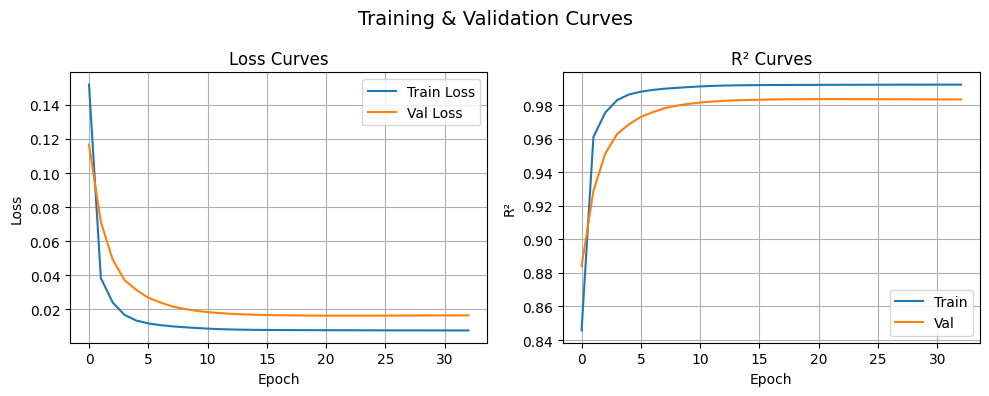

In [ ]:
# 1H custom LSTM training (horizon=1)
print("1H resolution model's training")
history1h_1h_lstm = train_custom_lstm(hour_train_loader, hour_val_loader)

# plot learning curves
plot_history(history1h_1h_lstm)

As we see, training an RNN, and even more an LSTM, from scratch takes a lot of time because we explicitly step through every time step in Python, updating the hidden state with lots of tiny matrix operations (mainly multiplacations). The LSTM adds multiple gates (input/update, forget, output) and a cell update (more computations per step), so it takes much longer than the RNN. Notice how much better the training times are when we switch to PyTorch's built-in RNN/LSTM modules.

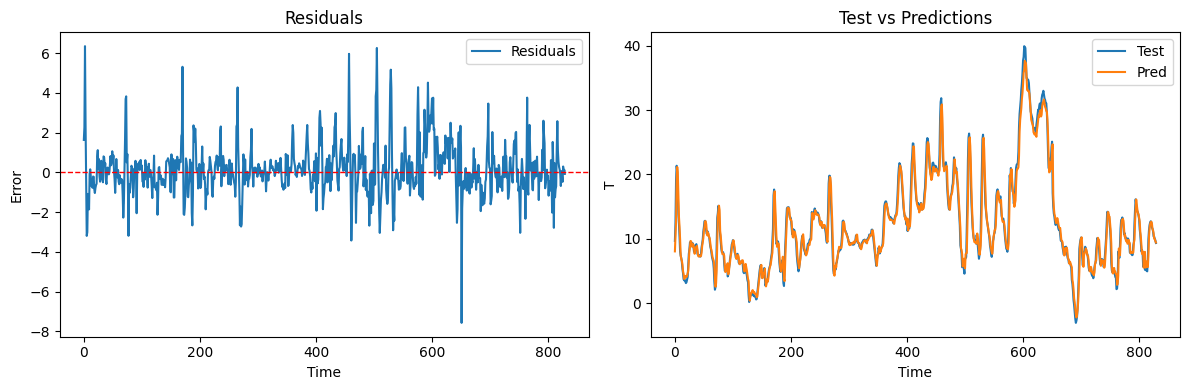


1H series (1 steps-ahead forecasts)
1H Custom LSTM Training Time: 9748.476
1H Custom LSTM Total Params: 16961
1H Custsom LSTM MAE: 0.87, RMSE: 1.27, MAPE: 11.21


In [ ]:
# predict (1-step ahead with 1H model)
lstm_preds1h_1h_last_norm, lstm_trues1h_1h_last_norm, _, _ = predict_custom_lstm(hour_test_loader, history1h_1h_lstm['params'])

# denormalize, plot and evaluate
lstm_preds1h_1h = denormalize(lstm_preds1h_1h_last_norm, hour_train_mean, hour_train_std)
lstm_trues1h = denormalize(lstm_trues1h_1h_last_norm, hour_train_mean, hour_train_std)
plot_residuals_preds(lstm_trues1h, lstm_preds1h_1h)
lstm_mae1, lstm_rmse1, lstm_mape1 = evaluate_model(lstm_trues1h, lstm_preds1h_1h)

print("\n1H series (1 steps-ahead forecasts)")
print("1H Custom LSTM Training Time:", history1h_1h_lstm['total_training_time'])
print(f"1H Custom LSTM Total Params:", history1h_1h_lstm['total_params'])
print(f"1H Custsom LSTM MAE: {lstm_mae1}, RMSE: {lstm_rmse1}, MAPE: {lstm_mape1}")

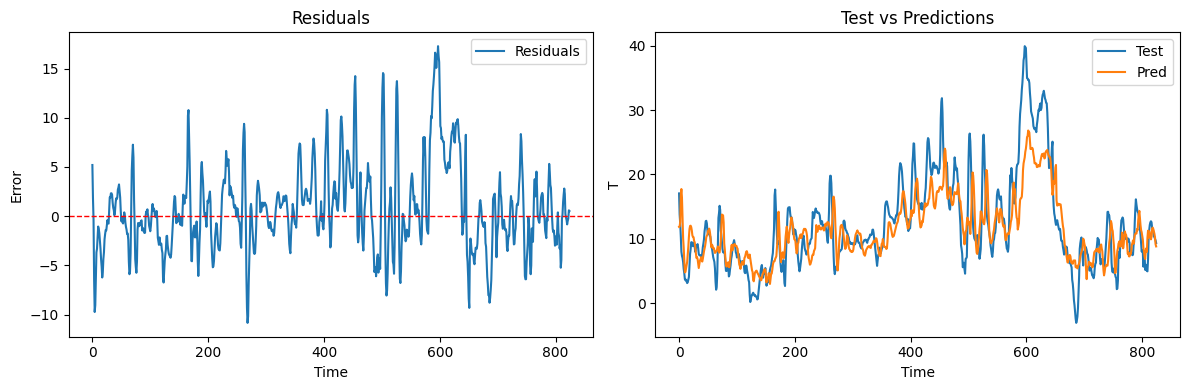


1H series (6 steps-ahead forecasts)
1H Custom LSTM MAE: 3.24, RMSE: 4.48, MAPE: 47.52


In [ ]:
# 1H custom LSTM training (horizon=6)

# remember here we need a test dataloader whose targets are the next 6 values per sample
lstm_preds1h_6h_last_norm, lstm_trues1h_6h_last_norm, _, _ = predict_custom_lstm(hour6_test_loader, history1h_1h_lstm['params'], n_steps=6)

# denormalize, plot and evaluate
lstm_preds1h_6h = denormalize(lstm_preds1h_6h_last_norm, hour_train_mean, hour_train_std)
lstm_trues1h_6h = denormalize(lstm_trues1h_6h_last_norm, hour_train_mean, hour_train_std)
plot_residuals_preds(lstm_trues1h_6h, lstm_preds1h_6h)
lstm_mae16, lstm_rmse16, lstm_mape16 = evaluate_model(lstm_trues1h_6h, lstm_preds1h_6h)

print("\n1H series (6 steps-ahead forecasts)")
print(f"1H Custom LSTM MAE: {lstm_mae16}, RMSE: {lstm_rmse16}, MAPE: {lstm_mape16}")

6H resolution model's training (horizon=1)
Epoch 10/100, Train Loss: 0.1896, Train R²: 0.8027 | Val Loss: 0.4416, Val R²: 0.4531
Epoch 20/100, Train Loss: 0.0843, Train R²: 0.9132 | Val Loss: 0.2287, Val R²: 0.7144
Epoch 30/100, Train Loss: 0.0770, Train R²: 0.9208 | Val Loss: 0.2253, Val R²: 0.7158
Early stopping at epoch 37 (no val loss improvement for 10 epochs).

Total training time: 2034.39 seconds
Total trainable parameters: 16961



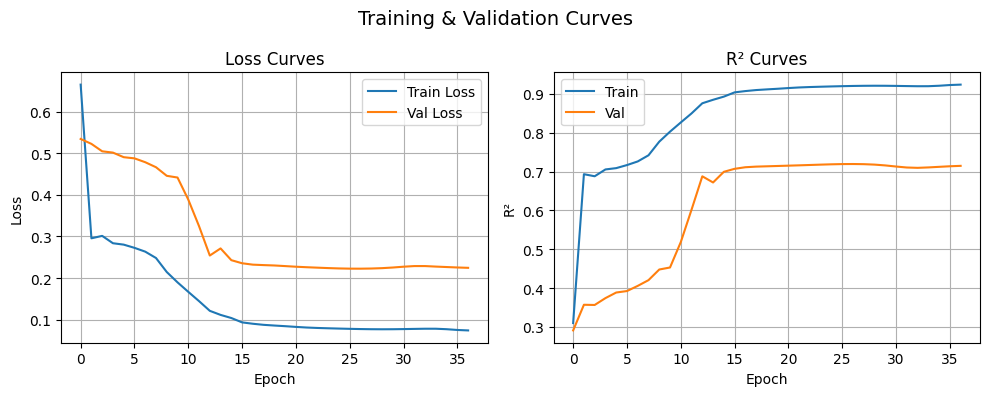

In [ ]:
# 6H custom LSTM training (horizon=1)
print("6H resolution model's training (horizon=1)")
history6h_1h_lstm = train_custom_lstm(six_train_loader, six_val_loader)

# plot learning curves
plot_history(history6h_1h_lstm)

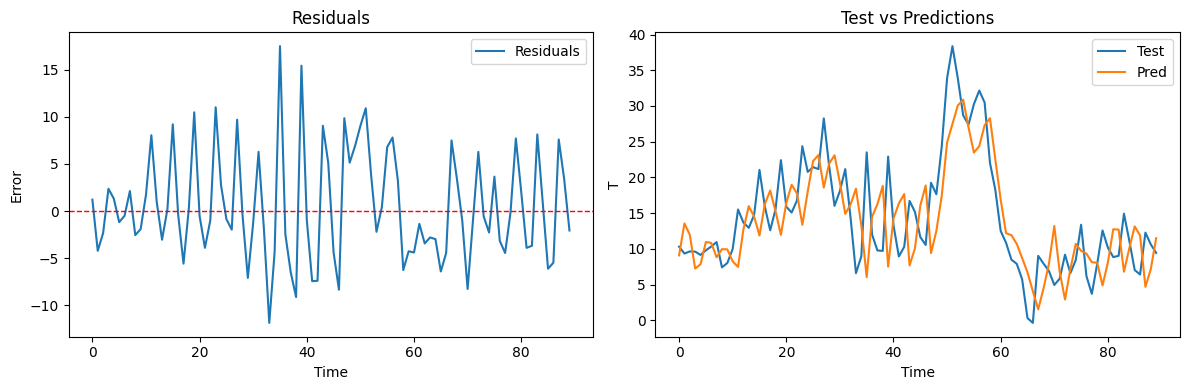


6H series (1 steps-ahead forecasts)
6H Custom LSTM Training Time: 2034.3857
6H Custom LSTM Total Params: 16961
6H Custsom LSTM MAE: 4.59, RMSE: 5.80, MAPE: 73.17


In [ ]:
# predict (1-step ahead with 6H model)
lstm_preds6h_1h_last_norm, lstm_trues6h_1h_last_norm, _, _ = predict_custom_lstm(six_test_loader, history6h_1h_lstm['params'])

# denormalize, plot and evaluate
lstm_preds6h_1h = denormalize(lstm_preds6h_1h_last_norm, six_train_mean, six_train_std)
lstm_trues6h_1h = denormalize(lstm_trues6h_1h_last_norm, six_train_mean, six_train_std)
plot_residuals_preds(lstm_trues6h_1h, lstm_preds6h_1h)
lstm_mae6, lstm_rmse6, lstm_mape6 = evaluate_model(lstm_trues6h_1h, lstm_preds6h_1h)

print("\n6H series (1 steps-ahead forecasts)")
print("6H Custom LSTM Training Time:", history6h_1h_lstm['total_training_time'])
print(f"6H Custom LSTM Total Params:", history6h_1h_lstm['total_params'])
print(f"6H Custsom LSTM MAE: {lstm_mae6}, RMSE: {lstm_rmse6}, MAPE: {lstm_mape6}")

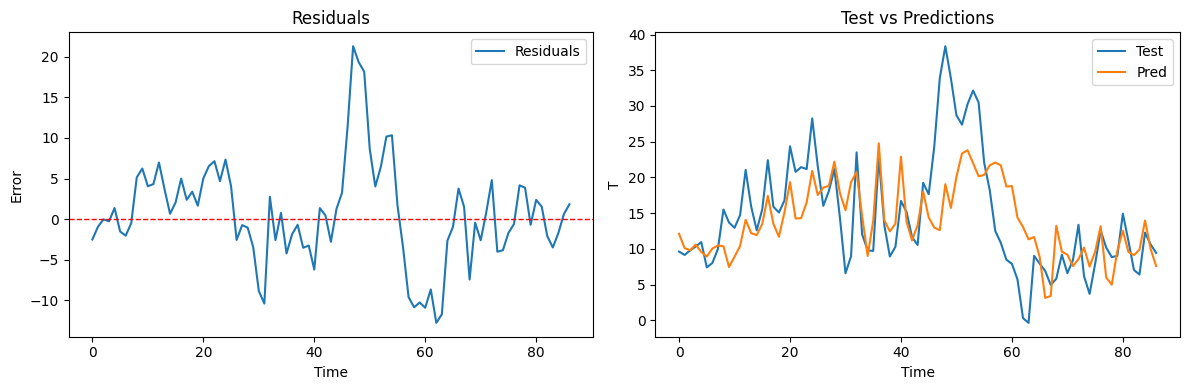


6H series (4 steps-ahead forecasts)
6H Custom LSTM MAE: 4.58, RMSE: 6.27, MAPE: 118.59


In [ ]:
# predict (4-steps ahead with 6H model)

# remember here we need a test dataloader whose targets are the next 6 values per sample
lstm_preds6h_4h_last_norm, lstm_trues6h_4h_last_norm, _, _ = predict_custom_lstm(six4_test_loader, history6h_1h_lstm['params'], n_steps=4)

# denormalize, plot and evaluate
lstm_preds6h_4h = denormalize(lstm_preds6h_4h_last_norm, six_train_mean, six_train_std)
lstm_trues6h_4h = denormalize(lstm_trues6h_4h_last_norm, six_train_mean, six_train_std)
plot_residuals_preds(lstm_trues6h_4h, lstm_preds6h_4h)
lstm_mae64, lstm_rmse64, lstm_mape64 = evaluate_model(lstm_trues6h_4h, lstm_preds6h_4h)

print("\n6H series (4 steps-ahead forecasts)")
print(f"6H Custom LSTM MAE: {lstm_mae64}, RMSE: {lstm_rmse64}, MAPE: {lstm_mape64}")

24H resolution model's training (horizon=1)
Epoch 10/100, Train Loss: 0.1968, Train R²: 0.7751 | Val Loss: 0.4336, Val R²: -1.1371
Epoch 20/100, Train Loss: 0.1755, Train R²: 0.7981 | Val Loss: 0.3656, Val R²: -0.8024
Epoch 30/100, Train Loss: 0.1551, Train R²: 0.8207 | Val Loss: 0.3713, Val R²: -0.8302
Early stopping at epoch 34 (no val loss improvement for 10 epochs).

Total training time: 218.22 seconds
Total trainable parameters: 16961



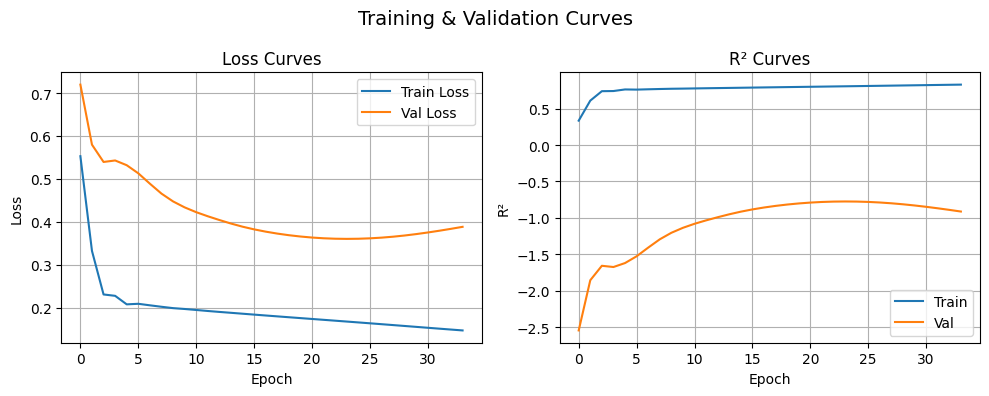

In [ ]:
# 24H custom LSTM training (horizon=1)
print("24H resolution model's training (horizon=1)")
history24h_1h_lstm = train_custom_lstm(day_train_loader, day_val_loader)

# plot learning curves
plot_history(history24h_1h_lstm)

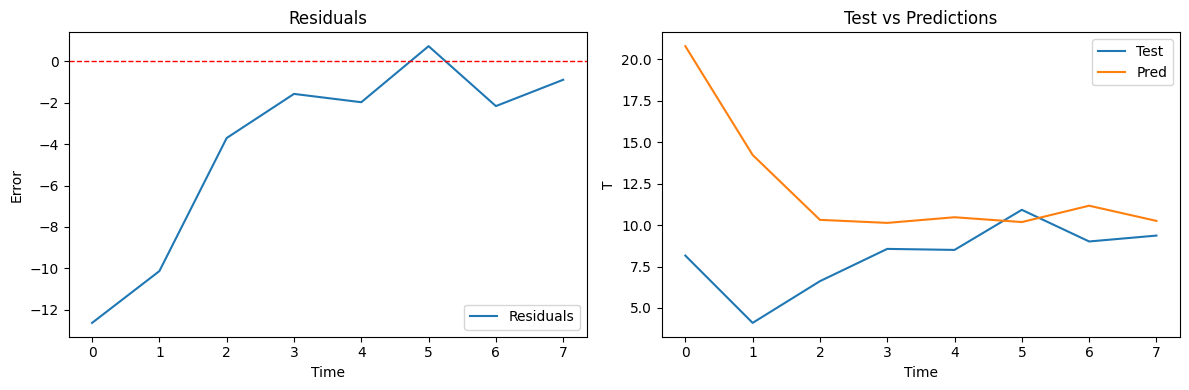


24H series (1 steps-ahead forecasts)
24H Custom LSTM Training Time: 218.2224
24H Custom LSTM Total Params: 16961
24H Custsom LSTM MAE: 4.23, RMSE: 6.01, MAPE: 67.49


In [ ]:
# predict (1-step ahead with 24H model)
lstm_preds24h_1h_last_norm, lstm_trues24h_1h_last_norm, _, _ = predict_custom_lstm(day_test_loader, history24h_1h_lstm['params'])

# denormalize, plot and evaluate
lstm_preds24h_1h = denormalize(lstm_preds24h_1h_last_norm, day_train_mean, day_train_std)
lstm_trues24h_1h = denormalize(lstm_trues24h_1h_last_norm, day_train_mean, day_train_std)
plot_residuals_preds(lstm_trues24h_1h, lstm_preds24h_1h)
lstm_mae24, lstm_rmse24, lstm_mape24 = evaluate_model(lstm_trues24h_1h, lstm_preds24h_1h)

print("\n24H series (1 steps-ahead forecasts)")
print("24H Custom LSTM Training Time:", history24h_1h_lstm['total_training_time'])
print(f"24H Custom LSTM Total Params:", history24h_1h_lstm['total_params'])
print(f"24H Custsom LSTM MAE: {lstm_mae24}, RMSE: {lstm_rmse24}, MAPE: {lstm_mape24}")

In [ ]:
lstm_results = [
    ("Custom LSTM", "1-hour", "t+1", "T_mean", "Univariate", lstm_mae1, lstm_rmse1, lstm_mape1, history1h_1h_lstm['total_training_time'], history1h_1h_lstm['total_params']),
    ("Custom LSTM", "1-hour", "t+6", "T_mean", "Univariate", lstm_mae16, lstm_rmse16, lstm_mape16, history1h_1h_lstm['total_training_time'], history1h_1h_lstm['total_params']),
    ("Custom LSTM", "6-hour", "t+1", "T_mean", "Univariate", lstm_mae6, lstm_rmse6, lstm_mape6, history6h_1h_lstm['total_training_time'], history6h_1h_lstm['total_params']),
    ("Custom LSTM", "6-hour", "t+4", "T_mean", "Univariate", lstm_mae64, lstm_rmse64, lstm_mape64, history6h_1h_lstm['total_training_time'], history6h_1h_lstm['total_params']),
    ("Custom LSTM", "24-hour", "t+1", "T_mean", "Univariate", lstm_mae24, lstm_rmse24, lstm_mape24, history24h_1h_lstm['total_training_time'], history24h_1h_lstm['total_params']),
]

In [ ]:
# print results
print(tabulate(lstm_results, headers=columns))

Model        Resolution    Horizon    Target Variable    Input Type      MAE    RMSE    MAPE (%)    Fit Time    # Params
-----------  ------------  ---------  -----------------  ------------  -----  ------  ----------  ----------  ----------
Custom LSTM  1-hour        t+1        T_mean             Univariate     0.87    1.27       11.21    9748.48        16961
Custom LSTM  1-hour        t+6        T_mean             Univariate     3.24    4.48       47.52    9748.48        16961
Custom LSTM  6-hour        t+1        T_mean             Univariate     4.59    5.8        73.17    2034.39        16961
Custom LSTM  6-hour        t+4        T_mean             Univariate     4.58    6.27      118.59    2034.39        16961
Custom LSTM  24-hour       t+1        T_mean             Univariate     4.23    6.01       67.49     218.222       16961


### Pytorch LSTM

In [ ]:
class mod_lstm(nn.Module):
  """
  Class for a simple modular LSTM model.
  """
  def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, num_layers=1):
    super(mod_lstm, self).__init__()

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h, _ = self.lstm(x)  # h: [batch_size, seq_len, hidden_dim]
    last_h_t = h[:, -1, :]  # take the output from the last time step (batch, hidden_dim)
    out = self.fc(last_h_t) # (batch, output_dim)
    return out

In [ ]:
# training with modular LSTM
print("1H resolution model's training")
mod_hour_history_lstm = train_mod_rnn(hour_train_loader, hour_val_loader, model_type='lstm')

print("6H resolution model's training")
mod_six_history_lstm = train_mod_rnn(six_train_loader, six_val_loader, model_type='lstm')

print("24H resolution model's training")
mod_day_history_lstm = train_mod_rnn(day_train_loader, day_val_loader, model_type='lstm')

1H resolution model's training
Epoch 10/100 | Train Loss: 0.0113 | Train R²: 0.9886 | Val Loss: 0.0214 | Val R²: 0.9781
Epoch 20/100 | Train Loss: 0.0079 | Train R²: 0.9920 | Val Loss: 0.0166 | Val R²: 0.9830
Epoch 30/100 | Train Loss: 0.0078 | Train R²: 0.9921 | Val Loss: 0.0159 | Val R²: 0.9837
Epoch 40/100 | Train Loss: 0.0077 | Train R²: 0.9921 | Val Loss: 0.0158 | Val R²: 0.9839
Early stopping at epoch 47 (no val loss improvement for 10 epochs).

Total training time: 33.22 seconds
Total trainable parameters: 17217

6H resolution model's training
Epoch 10/100 | Train Loss: 0.2887 | Train R²: 0.7027 | Val Loss: 0.4982 | Val R²: 0.3683
Epoch 20/100 | Train Loss: 0.2811 | Train R²: 0.7104 | Val Loss: 0.4799 | Val R²: 0.3915
Epoch 30/100 | Train Loss: 0.1408 | Train R²: 0.8550 | Val Loss: 0.2807 | Val R²: 0.6441
Epoch 40/100 | Train Loss: 0.0862 | Train R²: 0.9112 | Val Loss: 0.2378 | Val R²: 0.6985
Early stopping at epoch 45 (no val loss improvement for 10 epochs).

Total training tim

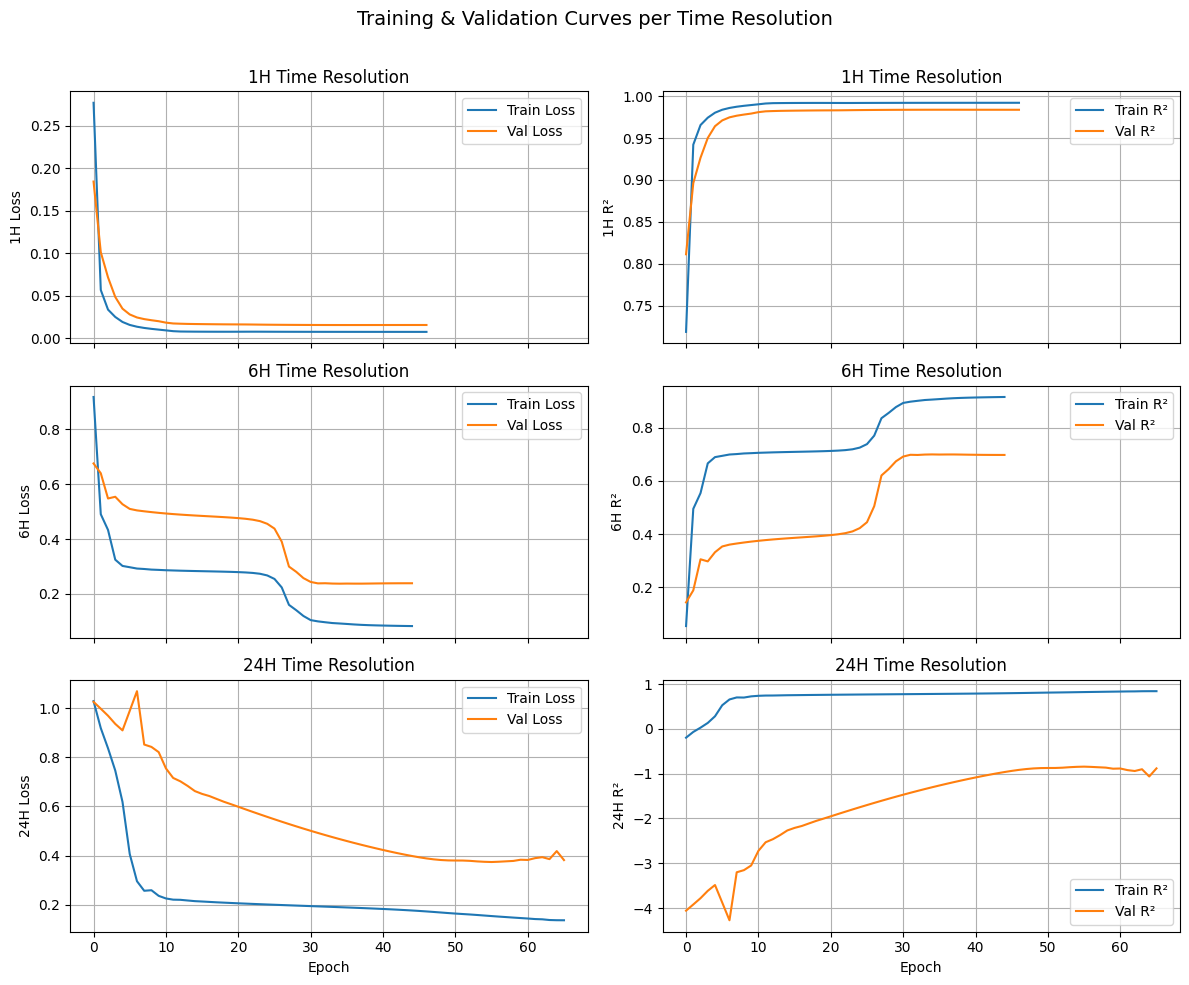

In [ ]:
# plot all learning curves at once
plot_learning_curves_all([mod_hour_history_lstm, mod_six_history_lstm, mod_day_history_lstm], ["1H", "6H", "24H"])

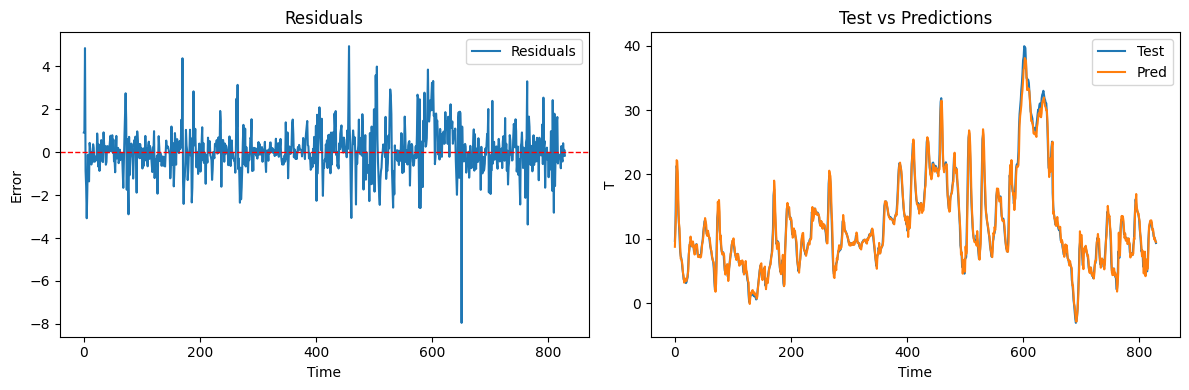


1H model Training Time: 33.2173
1H model Total Params: 17217
1H model (1-step): MAE=0.72, RMSE=1.05, MAPE=8.59


In [ ]:
# 1H model: 1-step ahead
hour_preds_mod_lstm, hour_trues_mod_lstm = predict_mod_rnn(mod_hour_history_lstm['model'], hour_test_loader)

# denormalize, plot and evaluate
preds1h_mod_lstm = denormalize(hour_preds_mod_lstm, hour_train_mean, hour_train_std)
trues1h_mod_lstm = denormalize(hour_trues_mod_lstm, hour_train_mean, hour_train_std)
plot_residuals_preds(trues1h_mod_lstm, preds1h_mod_lstm, "1H")
lstm_mae1, lstm_rmse1, lstm_mape1 = evaluate_model(trues1h_mod_lstm, preds1h_mod_lstm)

print(f"\n1H model Training Time: {mod_hour_history_lstm['total_training_time']}")
print(f"1H model Total Params: {mod_hour_history_lstm['total_params']}")
print(f"1H model (1-step): MAE={lstm_mae1}, RMSE={lstm_rmse1}, MAPE={lstm_mape1}")

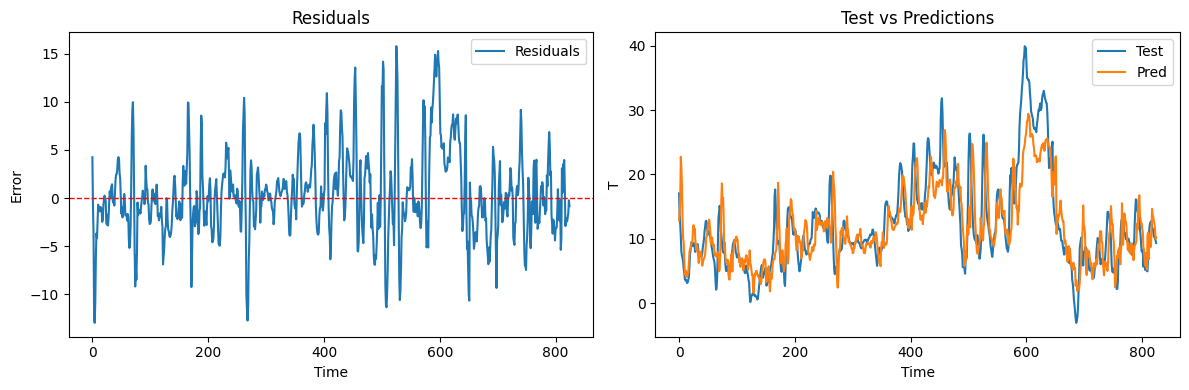


1H model (6-step): MAE=3.17, RMSE=4.38, MAPE=43.88


In [ ]:
# 1H model: 6-step ahead
hour6_preds_mod_lstm, hour6_trues_mod_lstm = predict_mod_rnn(mod_hour_history_lstm['model'], hour6_test_loader, n_steps=6)

# denormalize, plot and evaluate
preds1h_mod_lstm6 = denormalize(hour6_preds_mod_lstm, hour_train_mean, hour_train_std)
trues1h_mod_lstm6 = denormalize(hour6_trues_mod_lstm, hour_train_mean, hour_train_std)
plot_residuals_preds(trues1h_mod_lstm6, preds1h_mod_lstm6, "1H")
lstm_mae16, lstm_rmse16, lstm_mape16 = evaluate_model(trues1h_mod_lstm6, preds1h_mod_lstm6)

print(f"\n1H model (6-step): MAE={lstm_mae16}, RMSE={lstm_rmse16}, MAPE={lstm_mape16}")

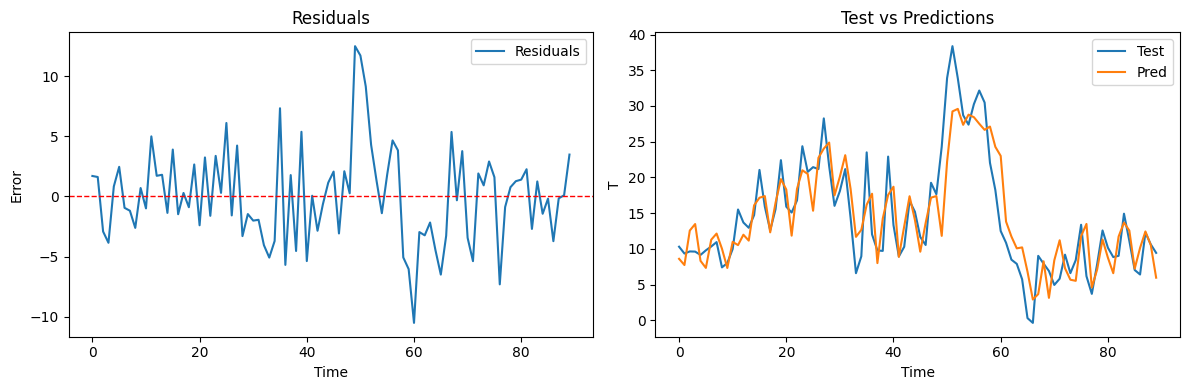


6H model Training Time: 5.2557
6H model Total Params: 17217
6H model (1-step): MAE=3.03, RMSE=3.91, MAPE=58.00


In [ ]:
# 6H model: 1-step ahead
six_preds_mod_lstm, six_trues_mod_lstm = predict_mod_rnn(mod_six_history_lstm['model'], six_test_loader)

# denormalize, plot and evaluate
preds6h_mod_lstm = denormalize(six_preds_mod_lstm, six_train_mean, six_train_std)
trues6h_mod_lstm = denormalize(six_trues_mod_lstm, six_train_mean, six_train_std)
plot_residuals_preds(trues6h_mod_lstm, preds6h_mod_lstm, "6H")
lstm_mae6, lstm_rmse6, lstm_mape6 = evaluate_model(trues6h_mod_lstm, preds6h_mod_lstm)

print(f"\n6H model Training Time: {mod_six_history_lstm['total_training_time']}")
print(f"6H model Total Params: {mod_six_history_lstm['total_params']}")
print(f"6H model (1-step): MAE={lstm_mae6}, RMSE={lstm_rmse6}, MAPE={lstm_mape6}")

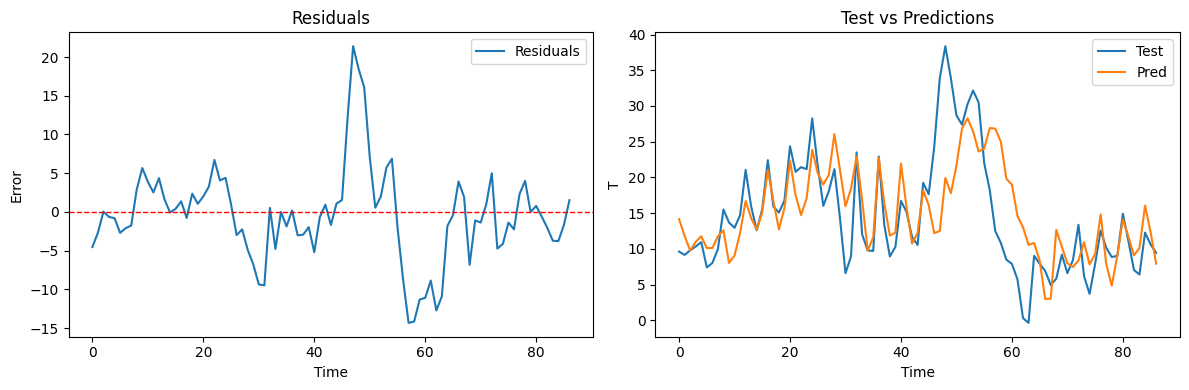


6H model (4-step): MAE=4.21, RMSE=6.08, MAPE=115.38


In [ ]:
# 6H model: 4-step ahead
six4_preds_mod_lstm, six4_trues_mod_lstm = predict_mod_rnn(mod_six_history_lstm['model'], six4_test_loader, n_steps=4)

# denormalize, plot and evaluate
preds6h_mod_lstm4 = denormalize(six4_preds_mod_lstm, six_train_mean, six_train_std)
six4_trues_mod_lstm = denormalize(six4_trues_mod_lstm, six_train_mean, six_train_std)
plot_residuals_preds(six4_trues_mod_lstm, preds6h_mod_lstm4, "6H")
lstm_mae64, lstm_rmse64, lstm_mape64 = evaluate_model(six4_trues_mod_lstm, preds6h_mod_lstm4)

print(f"\n6H model (4-step): MAE={lstm_mae64}, RMSE={lstm_rmse64}, MAPE={lstm_mape64}")

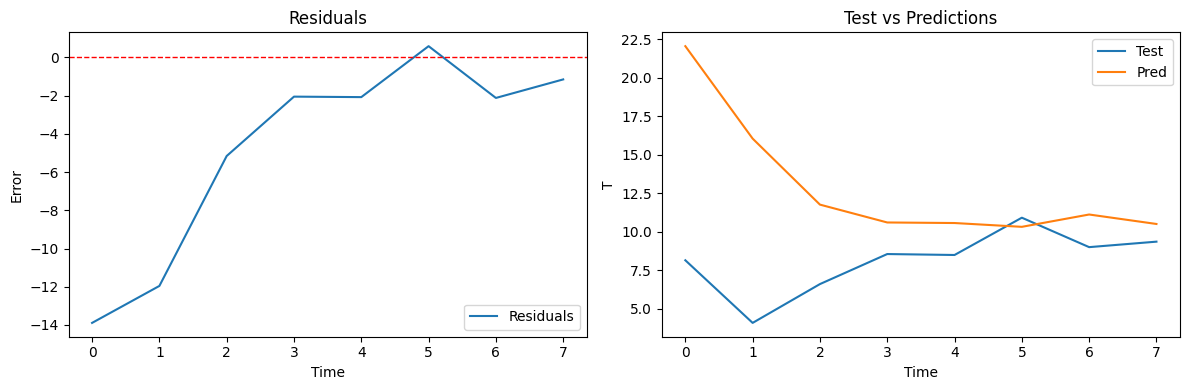


24H model Training Time: 1.9595
24H model Total Params: 17217
24H model (1-step): MAE=4.87, RMSE=6.87, MAPE=78.67


In [ ]:
# 24H model: 1-step ahead
day_preds_mod_lstm, day_trues_mod_lstm = predict_mod_rnn(mod_day_history_lstm['model'], day_test_loader)

# denormalize, plot and evaluate
preds24h_mod_lstm = denormalize(day_preds_mod_lstm, day_train_mean, day_train_std)
day_trues_mod_lstm = denormalize(day_trues_mod_lstm, day_train_mean, day_train_std)
plot_residuals_preds(day_trues_mod_lstm, preds24h_mod_lstm, "24H")
lstm_mae24, lstm_rmse24, lstm_mape24 = evaluate_model(day_trues_mod_lstm, preds24h_mod_lstm)

print(f"\n24H model Training Time: {mod_day_history_lstm['total_training_time']}")
print(f"24H model Total Params: {mod_day_history_lstm['total_params']}")
print(f"24H model (1-step): MAE={lstm_mae24}, RMSE={lstm_rmse24}, MAPE={lstm_mape24}")

In [ ]:
# collect evaluation results for modular lstm results for all time resolutions
lstm_results += [
    ("Modular LSTM", "1-hour", "t+1", "T_mean", "Univariate", lstm_mae1, lstm_rmse1, lstm_mape1, mod_hour_history_lstm['total_training_time'], mod_hour_history_lstm['total_params']),
    ("Modular LSTM", "1-hour", "t+6", "T_mean", "Univariate", lstm_mae16, lstm_rmse16, lstm_mape16, mod_hour_history_lstm['total_training_time'], mod_hour_history_lstm['total_params']),
    ("Modular LSTM", "6-hour", "t+1", "T_mean", "Univariate", lstm_mae6, lstm_rmse6, lstm_mape6, mod_six_history_lstm['total_training_time'], mod_six_history_lstm['total_params']),
    ("Modular LSTM", "6-hour", "t+4", "T_mean", "Univariate", lstm_mae64, lstm_rmse64, lstm_mape64, mod_six_history_lstm['total_training_time'], mod_six_history_lstm['total_params']),
    ("Modular LSTM", "24-hour", "t+1", "T_mean", "Univariate", lstm_mae24, lstm_rmse24, lstm_mape24, mod_day_history_lstm['total_training_time'], mod_day_history_lstm['total_params']),
]

In [ ]:
# print all the results up to now
print(tabulate(lstm_results, headers=columns))

Model         Resolution    Horizon    Target Variable    Input Type      MAE    RMSE    MAPE (%)    Fit Time    # Params
------------  ------------  ---------  -----------------  ------------  -----  ------  ----------  ----------  ----------
Custom LSTM   1-hour        t+1        T_mean             Univariate     0.87    1.27       11.21   9748.48         16961
Custom LSTM   1-hour        t+6        T_mean             Univariate     3.24    4.48       47.52   9748.48         16961
Custom LSTM   6-hour        t+1        T_mean             Univariate     4.59    5.8        73.17   2034.39         16961
Custom LSTM   6-hour        t+4        T_mean             Univariate     4.58    6.27      118.59   2034.39         16961
Custom LSTM   24-hour       t+1        T_mean             Univariate     4.23    6.01       67.49    218.222        16961
Modular LSTM  1-hour        t+1        T_mean             Univariate     0.72    1.05        8.59     33.2173       17217
Modular LSTM  1-hour    

## Stacked RNNs/LSTMs

Stacked units simply means adding one more RNN/LSTM layer on top of the existing one, so the output of the lower layer becomes the input to the next ([Difference between 1 LSTM with num_layers](https://stackoverflow.com/questions/49224413/difference-between-1-lstm-with-num-layers-2-and-2-lstms-in-pytorch?utm_source=chatgpt.com)).

In [ ]:
# input sample: x.shape = (48, 1, 1)
input_size = x.shape[-1] # 1 (temperature)
hidden_size = 4 # hidden dimension
num_layers = 2 # stacked LSTM (2 layers)

lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=False)

# forward pass
output, (h_n, c_n) = lstm(x)

In [ ]:
print("Stacked LSTM outputs")
print("output of all hidden states for all timesteps of sequence length:", output.shape, "(sequence of context vectors, one per timestep, from the top layer)")
print("h_n (last hidden state of each layer):", h_n.shape, "(num_layers, batch, hidden_size)")
print("c_n (last cell state of each layer):", c_n.shape, "(num_layers, batch, hidden_size)")

print("\nExample:")
print("At time t, output[t] is the hidden state (from top layer) after t steps:", output[0].shape)
print("Final hidden state from top layer:", h_n[-1].shape)

Stacked LSTM outputs
output of all hidden states for all timesteps of sequence length: torch.Size([48, 1, 4]) (sequence of context vectors, one per timestep, from the top layer)
h_n (last hidden state of each layer): torch.Size([2, 1, 4]) (num_layers, batch, hidden_size)
c_n (last cell state of each layer): torch.Size([2, 1, 4]) (num_layers, batch, hidden_size)

Example:
At time t, output[t] is the hidden state (from top layer) after t steps: torch.Size([1, 4])
Final hidden state from top layer: torch.Size([1, 4])


As we saw earlier in the custom LSTM, for each timestep of a sample (e.g. 48 values), the input scalar is transformed into hidden states across several units (here 4). In a stacked LSTM with 2 layers, the hidden states from the first layer are passed as inputs to the second layer, giving an output of shape (48, 1, 4) from the top layer. The final hidden states (2, 1, 4) and cell states (2, 1, 4) summarize the sequence at each layer, with the top layer's last hidden state serving as the overall context vector.

In [ ]:
# deep stucked RNNs/LSTMs
class DeepRNN(nn.Module):
  def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, num_layers=2, dropout=0.0):
    super().__init__()
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x): # x: (B, L, input_dim)
    h, _ = self.rnn(x) # h: (B, L, hidden_dim)
    last_h = h[:, -1, :] # (B, hidden_dim)
    out = self.fc(last_h) # (B, output_dim)
    return out


class DeepLSTM(nn.Module):
  def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, num_layers=2, dropout=0.0):
    super().__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x): # x: (B, L, input_dim)
    h, _ = self.lstm(x) # h: (B, L, hidden_dim)
    last_h = h[:, -1, :] # (B, hidden_dim)
    out = self.fc(last_h) # (B, output_dim)
    return out

In [ ]:
#
def train_deep_seq(train_loader, val_loader, model_type='lstm', input_dim=1, hidden_dim=64, output_dim=1, num_layers=2, dropout=0.2, epochs=100, lr=1e-3, weight_decay=1e-4, patience=10, verbose_every=10):
  """
  Trains a deep (stacked) RNN/LSTM with early stopping. Returns a history dict with the model and metrics.

  Args:
    train_loader: DataLoader for training data
    val_loader: DataLoader for validation data
    model_type: 'rnn' or 'lstm'
    input_dim: input dimension
    hidden_dim: hidden dimension
    output_dim: output dimension
    num_layers: number of layers
    dropout: dropout rate
    epochs: number of epochs
    lr: learning rate
    weight_decay: weight decay
    patience: early stopping patience
    verbose_every: print progress every verbose_every epochs

  Returns:
    history: dict with the following keys:
      - model: trained model
      - total_training_time: total training time
      - total_params: total number of trainable parameters
      - best_val_loss: best validation loss
      - best_epoch: epoch with best validation loss
      - stopped_epoch: epoch with early stopping
      - train_loss: list of training loss per epoch
      - train_r2: list of training R² per epoch
      - val_loss: list of validation loss per epoch
      - val_r2: list of validation R² per epoch
  """
  device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # build model
  if model_type.lower() == 'rnn':
    model = DeepRNN(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
  elif model_type.lower() == 'lstm':
    model = DeepLSTM(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)
  else:
    raise ValueError("model_type must be 'rnn' or 'lstm'.")

  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  loss_fn = nn.MSELoss()

  history = {"train_loss": [], "train_r2": [], "val_loss": [], "val_r2": []}

  # early stopping state
  best_val = float('inf')
  best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
  best_epoch = 0
  no_improve = 0

  start = time.time()
  for epoch in range(epochs):
    # train
    model.train()
    train_loss_sum, seen = 0.0, 0
    train_preds, train_trues = [], []

    for Xb, yb in train_loader:
      Xb, yb = Xb.to(device), yb.to(device)
      if yb.ndim == 1:
        yb = yb.view(-1, 1) # (B,1)

      pred = model(Xb) # (B,1)
      loss = loss_fn(pred, yb)

      opt.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
      opt.step()

      B = Xb.size(0)
      train_loss_sum += loss.item() * B
      seen += B
      train_preds.append(pred.detach().view(-1).cpu())
      train_trues.append(yb.detach().view(-1).cpu())

    train_loss = train_loss_sum / max(1, seen)
    train_preds = torch.cat(train_preds) if train_preds else torch.empty(0)
    train_trues = torch.cat(train_trues) if train_trues else torch.empty(0)
    train_r2 = r2_fn(train_trues, train_preds) if len(train_trues) else 0.0

    # val
    model.eval()
    val_loss_sum, vseen = 0.0, 0
    val_preds, val_trues = [], []
    with torch.no_grad():
      for Xb, yb in val_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        if yb.ndim == 1:
          yb = yb.view(-1, 1)

        pred = model(Xb)
        loss = loss_fn(pred, yb)

        B = Xb.size(0)
        val_loss_sum += loss.item() * B
        vseen += B
        val_preds.append(pred.detach().view(-1).cpu())
        val_trues.append(yb.detach().view(-1).cpu())

    val_loss = val_loss_sum / max(1, vseen)
    val_preds = torch.cat(val_preds) if val_preds else torch.empty(0)
    val_trues = torch.cat(val_trues) if val_trues else torch.empty(0)
    val_r2 = r2_fn(val_trues, val_preds) if len(val_trues) else 0.0

    history["train_loss"].append(train_loss)
    history["train_r2"].append(train_r2)
    history["val_loss"].append(val_loss)
    history["val_r2"].append(val_r2)

    if (epoch + 1) % verbose_every == 0:
      print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train R²: {train_r2:.4f} | " f"Val Loss: {val_loss:.4f} | Val R²: {val_r2:.4f}")

    # early stopping
    if val_loss + 1e-8 < best_val:
      best_val = val_loss
      best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
      best_epoch = epoch + 1
      no_improve = 0
    else:
      no_improve += 1
      if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} (no val loss improvement for {patience} epochs).")
        break

  total_training_time = time.time() - start

  # restore best state
  model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
  total_params = count_trainable_params(model.parameters())

  history.update({
      "model": model,
      "total_training_time": round(total_training_time, 4),
      "total_params": total_params,
      "best_val_loss": float(best_val),
      "best_epoch": best_epoch,
      "stopped_epoch": epoch + 1
    })
  return history

In [ ]:
# deep LSTM (stacked) training
print("Deep LSTM — 1H resolution model's training")
deep_hour_hist_lstm = train_deep_seq(hour_train_loader, hour_val_loader, model_type='lstm')

print("\nDeep LSTM — 6H resolution model's training")
deep_six_hist_lstm = train_deep_seq(six_train_loader, six_val_loader, model_type='lstm')

print("\nDeep LSTM — 24H resolution model's training")
deep_day_hist_lstm = train_deep_seq(day_train_loader, day_val_loader, model_type='lstm')

Deep LSTM — 1H resolution model's training
Epoch 10/100 | Train Loss: 0.0147 | Train R²: 0.9850 | Val Loss: 0.0184 | Val R²: 0.9812
Epoch 20/100 | Train Loss: 0.0118 | Train R²: 0.9881 | Val Loss: 0.0180 | Val R²: 0.9816
Early stopping at epoch 29 (no val loss improvement for 10 epochs).

Deep LSTM — 6H resolution model's training
Epoch 10/100 | Train Loss: 0.3008 | Train R²: 0.6902 | Val Loss: 0.4982 | Val R²: 0.3683
Epoch 20/100 | Train Loss: 0.2880 | Train R²: 0.7033 | Val Loss: 0.4790 | Val R²: 0.3927
Epoch 30/100 | Train Loss: 0.2240 | Train R²: 0.7693 | Val Loss: 0.4308 | Val R²: 0.4538
Epoch 40/100 | Train Loss: 0.1085 | Train R²: 0.8882 | Val Loss: 0.2553 | Val R²: 0.6763
Epoch 50/100 | Train Loss: 0.0890 | Train R²: 0.9083 | Val Loss: 0.2488 | Val R²: 0.6845
Early stopping at epoch 52 (no val loss improvement for 10 epochs).

Deep LSTM — 24H resolution model's training
Epoch 10/100 | Train Loss: 0.2288 | Train R²: 0.7340 | Val Loss: 0.7736 | Val R²: -2.8131
Epoch 20/100 | Trai

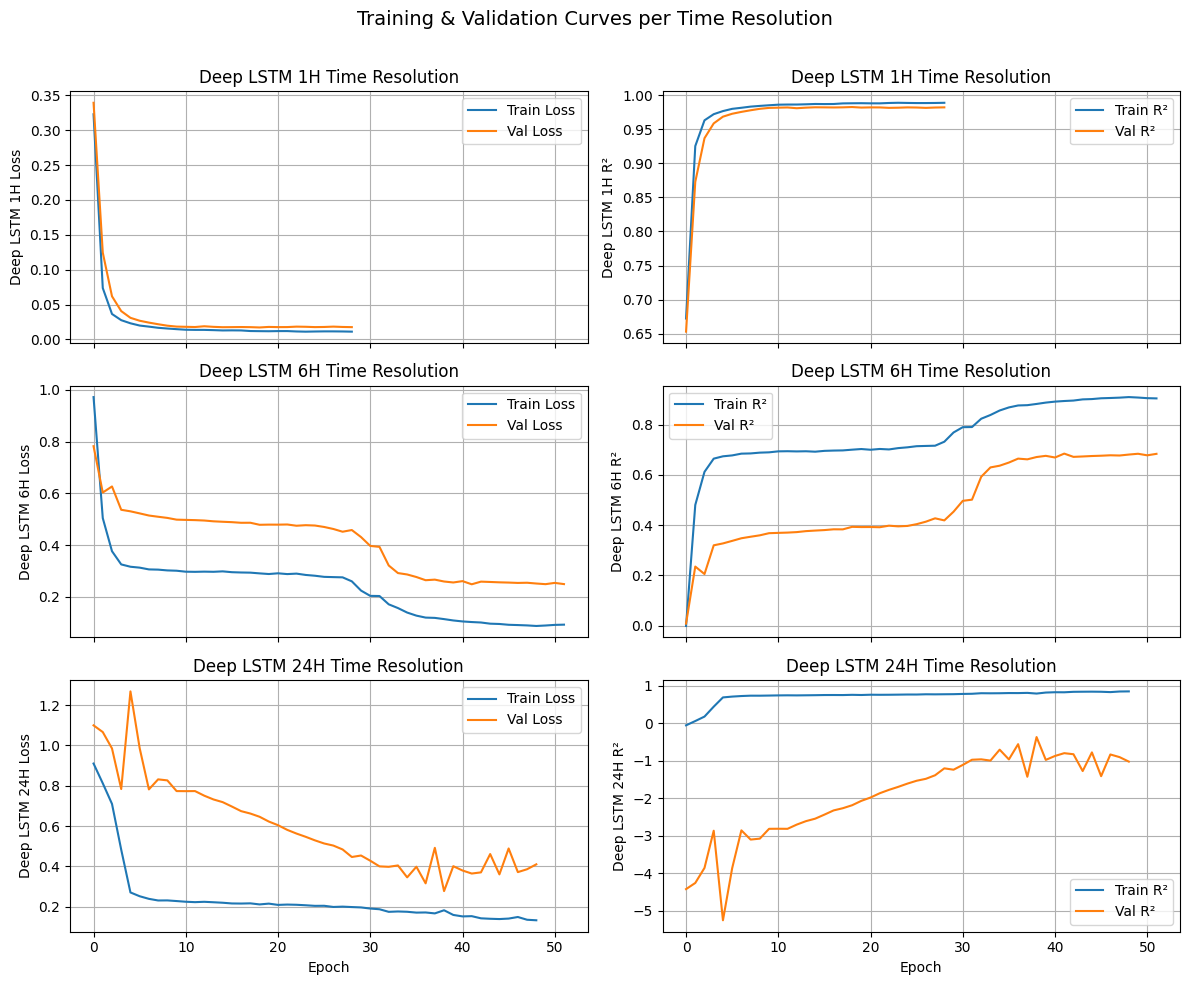

In [ ]:
# plot curves
plot_learning_curves_all([deep_hour_hist_lstm, deep_six_hist_lstm, deep_day_hist_lstm], ["Deep LSTM 1H", "Deep LSTM 6H", "Deep LSTM 24H"])

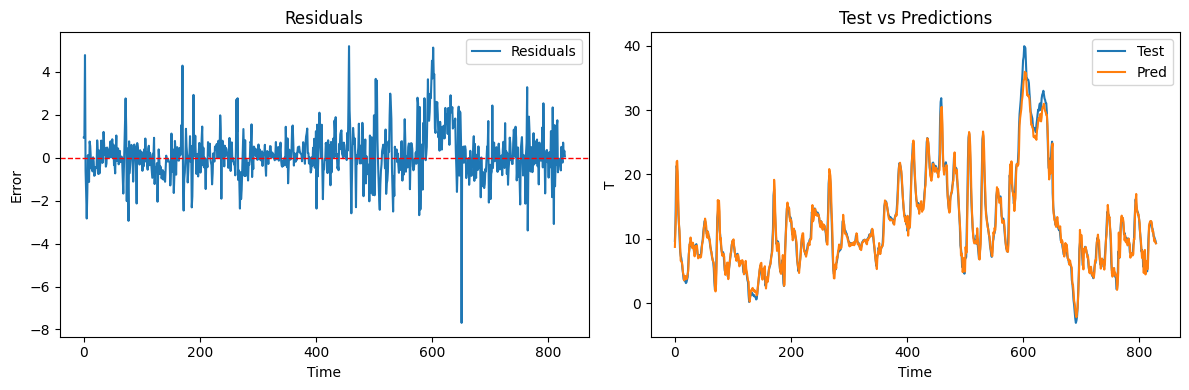


Deep LSTM 1H: Training Time: 22.365
Deep LSTM 1H (t+1): MAE=0.77, RMSE=1.13, MAPE=9.85


In [ ]:
# 1H model: 1-step
dl_hour_p1, dl_hour_t1 = predict_mod_rnn(deep_hour_hist_lstm['model'], hour_test_loader, n_steps=1)
p1 = denormalize(dl_hour_p1, hour_train_mean, hour_train_std)
t1 = denormalize(dl_hour_t1, hour_train_mean, hour_train_std)
plot_residuals_preds(t1, p1, "Deep LSTM 1H (t+1)")
dl_mae1, dl_rmse1, dl_mape1 = evaluate_model(t1, p1)

print(f"\nDeep LSTM 1H: Training Time: {deep_hour_hist_lstm['total_training_time']}")
print(f"Deep LSTM 1H (t+1): MAE={dl_mae1}, RMSE={dl_rmse1}, MAPE={dl_mape1}")

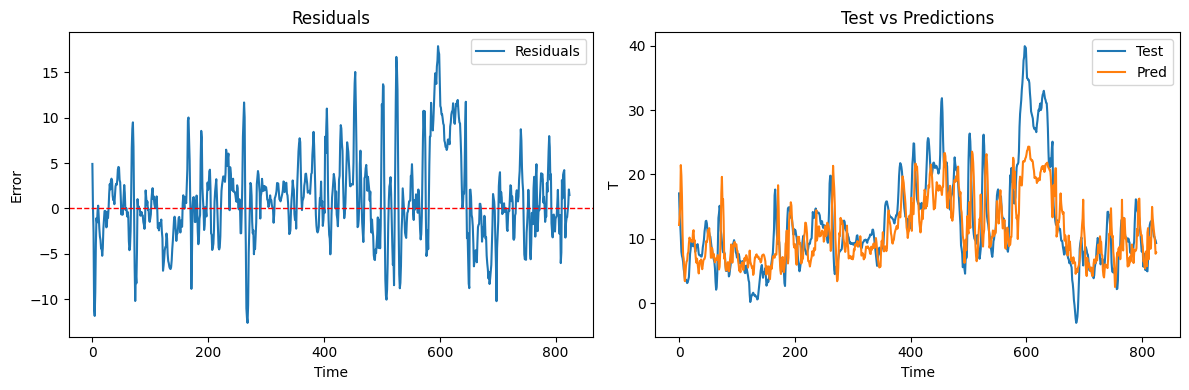


Deep LSTM 1H (t+6): MAE=3.55, RMSE=4.86, MAPE=51.43


In [ ]:
# 1H model: 6-step (use test loader for horizon=6)
dl_hour_p6, dl_hour_t6 = predict_mod_rnn(deep_hour_hist_lstm['model'], hour6_test_loader, n_steps=6)
p6 = denormalize(dl_hour_p6, hour_train_mean, hour_train_std)
t6 = denormalize(dl_hour_t6, hour_train_mean, hour_train_std)
plot_residuals_preds(t6, p6, "Deep LSTM 1H (t+6)")
dl_mae16, dl_rmse16, dl_mape16 = evaluate_model(t6, p6)

print(f"\nDeep LSTM 1H (t+6): MAE={dl_mae16}, RMSE={dl_rmse16}, MAPE={dl_mape16}")

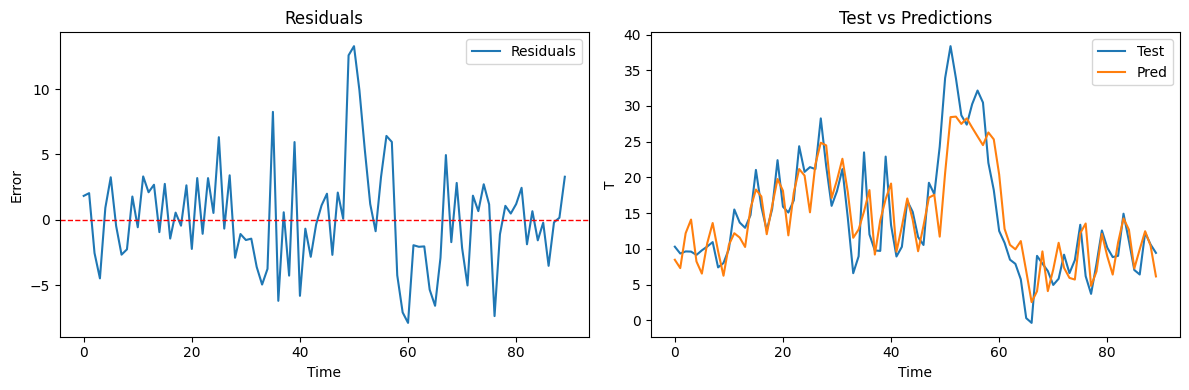


Deep LSTM 6H: Training Time: 6.6033
Deep LSTM 6H (t+1): MAE=3.00, RMSE=3.97, MAPE=56.54


In [ ]:
# 6H model: 1-step
dl_six_p1, dl_six_t1 = predict_mod_rnn(deep_six_hist_lstm['model'], six_test_loader, n_steps=1)
p6_1 = denormalize(dl_six_p1, six_train_mean, six_train_std)
t6_1 = denormalize(dl_six_t1, six_train_mean, six_train_std)
plot_residuals_preds(t6_1, p6_1, "Deep LSTM 6H (t+1)")
dl_mae6, dl_rmse6, dl_mape6 = evaluate_model(t6_1, p6_1)

print(f"\nDeep LSTM 6H: Training Time: {deep_six_hist_lstm['total_training_time']}")
print(f"Deep LSTM 6H (t+1): MAE={dl_mae6}, RMSE={dl_rmse6}, MAPE={dl_mape6}")

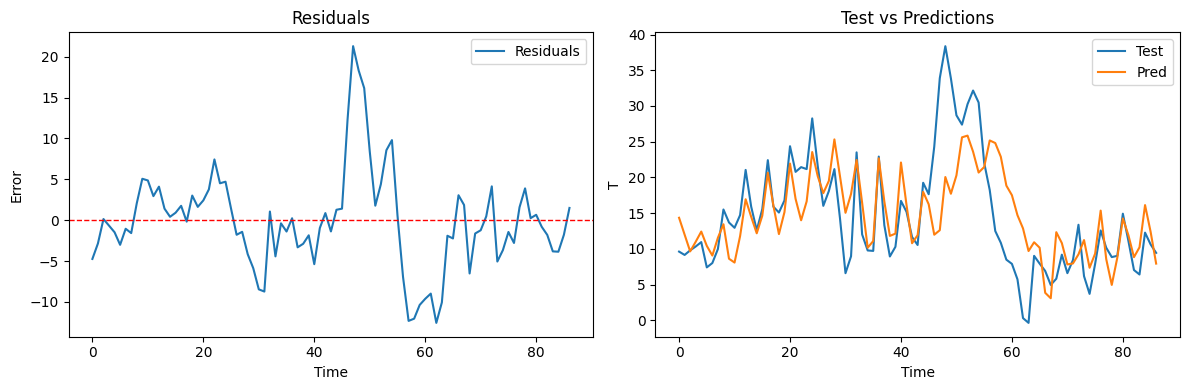


Deep LSTM 6H (t+4): MAE=4.21, RMSE=5.96, MAPE=111.18


In [ ]:
# 6H model: 4-step (use test loader for horizon=4)
dl_six_p4, dl_six_t4 = predict_mod_rnn(deep_six_hist_lstm['model'], six4_test_loader, n_steps=4)
p6_4 = denormalize(dl_six_p4, six_train_mean, six_train_std)
t6_4 = denormalize(dl_six_t4, six_train_mean, six_train_std)
plot_residuals_preds(t6_4, p6_4, "Deep LSTM 6H (t+4)")
dl_mae64, dl_rmse64, dl_mape64 = evaluate_model(t6_4, p6_4)

print(f"\nDeep LSTM 6H (t+4): MAE={dl_mae64}, RMSE={dl_rmse64}, MAPE={dl_mape64}")

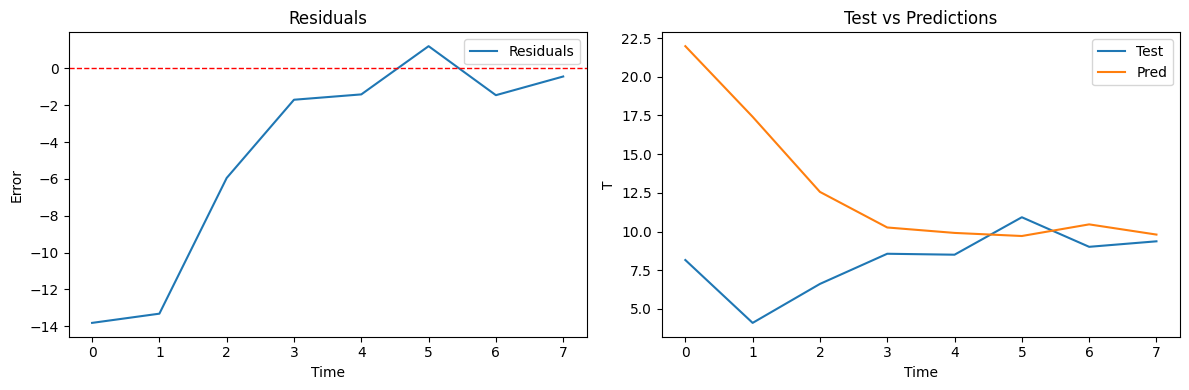


Deep LSTM 24H: Training Time: 1.571
Deep LSTM 24H (t+1): MAE=4.91, RMSE=7.18, MAPE=81.53


In [ ]:
# 24H model: 1-step
dl_day_p1, dl_day_t1 = predict_mod_rnn(deep_day_hist_lstm['model'], day_test_loader, n_steps=1)
p24 = denormalize(dl_day_p1, day_train_mean, day_train_std)
t24 = denormalize(dl_day_t1, day_train_mean, day_train_std)
plot_residuals_preds(t24, p24, "Deep LSTM 24H (t+1)")
dl_mae24, dl_rmse24, dl_mape24 = evaluate_model(t24, p24)

print(f"\nDeep LSTM 24H: Training Time: {deep_day_hist_lstm['total_training_time']}")
print(f"Deep LSTM 24H (t+1): MAE={dl_mae24}, RMSE={dl_rmse24}, MAPE={dl_mape24}")

In [ ]:
lstm_results += [
    ("Deep LSTM", "1-hour",  "t+1", "T_mean", "Univariate", dl_mae1,  dl_rmse1,  dl_mape1,  deep_hour_hist_lstm['total_training_time'], deep_hour_hist_lstm['total_params']),
    ("Deep LSTM", "1-hour",  "t+6", "T_mean", "Univariate", dl_mae16, dl_rmse16, dl_mape16, deep_hour_hist_lstm['total_training_time'], deep_hour_hist_lstm['total_params']),
    ("Deep LSTM", "6-hour",  "t+1", "T_mean", "Univariate", dl_mae6,  dl_rmse6,  dl_mape6,  deep_six_hist_lstm['total_training_time'],  deep_six_hist_lstm['total_params']),
    ("Deep LSTM", "6-hour",  "t+4", "T_mean", "Univariate", dl_mae64, dl_rmse64, dl_mape64, deep_six_hist_lstm['total_training_time'],  deep_six_hist_lstm['total_params']),
    ("Deep LSTM", "24-hour", "t+1", "T_mean", "Univariate", dl_mae24, dl_rmse24, dl_mape24, deep_day_hist_lstm['total_training_time'],  deep_day_hist_lstm['total_params']),
]

In [ ]:
# print all rsults
print(tabulate(lstm_results, headers=columns))

Model         Resolution    Horizon    Target Variable    Input Type      MAE    RMSE    MAPE (%)    Fit Time    # Params
------------  ------------  ---------  -----------------  ------------  -----  ------  ----------  ----------  ----------
Custom LSTM   1-hour        t+1        T_mean             Univariate     0.87    1.27       11.21   9748.48         16961
Custom LSTM   1-hour        t+6        T_mean             Univariate     3.24    4.48       47.52   9748.48         16961
Custom LSTM   6-hour        t+1        T_mean             Univariate     4.59    5.8        73.17   2034.39         16961
Custom LSTM   6-hour        t+4        T_mean             Univariate     4.58    6.27      118.59   2034.39         16961
Custom LSTM   24-hour       t+1        T_mean             Univariate     4.23    6.01       67.49    218.222        16961
Modular LSTM  1-hour        t+1        T_mean             Univariate     0.72    1.05        8.59     33.2173       17217
Modular LSTM  1-hour    

## Results

In [ ]:
# combine and print all the above results
all_rnn_results = rnn_results + lstm_results
print(tabulate(all_rnn_results, headers=columns, tablefmt="github", floatfmt=".2f"))

| Model        | Resolution   | Horizon   | Target Variable   | Input Type   |   MAE |   RMSE |   MAPE (%) |   Fit Time |   # Params |
|--------------|--------------|-----------|-------------------|--------------|-------|--------|------------|------------|------------|
| Custom RNN   | 1-hour       | t+1       | T_mean            | Univariate   |  0.86 |   1.25 |      11.15 |    1402.05 |       4289 |
| Custom RNN   | 1-hour       | t+6       | T_mean            | Univariate   |  3.28 |   4.33 |      47.81 |    1402.05 |       4289 |
| Custom RNN   | 6-hour       | t+1       | T_mean            | Univariate   |  4.52 |   5.75 |      79.03 |     328.83 |       4289 |
| Custom RNN   | 6-hour       | t+4       | T_mean            | Univariate   |  4.43 |   6.32 |     121.96 |     328.83 |       4289 |
| Custom RNN   | 24-hour      | t+1       | T_mean            | Univariate   |  3.55 |   5.44 |      58.01 |      21.88 |       4289 |
| Modular RNN  | 1-hour       | t+1       | T_mean     

**Key Takeaways**

*   **Model capacity (params):** As expected, Modular (PyTorch) models carry more parameters than the Custom (from-scratch) ones, and Deep (stacked) LSTM has the larger architectural complexity.

*   **Fit time tracks data & complexity.** Training time scales with (a) number of sequences in the resolution and (b) operations/parameters. That's why Modular RNN at 24H is the quickest (fewest samples) while Custom LSTM at 1H is by far the slowest.

*   **Performance:** modular > custom. Across resolutions, Modular implementations beat Custom ones, benefiting from optimized kernels, better initialization, etc.

*   **Depth helps (to a point).** Deep LSTM generally performs better than a single-layer Modular LSTM as extra layers capture longer/complex dependencies. Although gains can depend on window size, regularization, etc. and the differences may be minor (e.g. Modular RNN slightly better than Deep LSTM).

*   **Horizon mismatch isn't guaranteed to win.** Using a 1H-resolution model to roll out to t+4 / t+6 doesn't always beat a model trained at the native resolution (e.g. 6H or 24H).

*   **Error grows with horizon.** MAE/RMSE/ MAPΕ are lowest for t+1 and worsen as the horizon lengthens, exactly what we expect, due to compounding uncertainty.

*   **Params vs. accuracy trade-off.** The best scores come from the largest models, but at much higher training time.

*Final note:* if you are thinking to implement sequence models from scratch… think twice and go straight to **modular PyTorch + GPU**. Your future self will thank you!

In [ ]:
# save and download all_results
all_results_df = pd.DataFrame(all_rnn_results, columns=columns)
all_results_df.to_csv("rnn_results.csv", index=False)
files.download("rnn_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# save and download dataloaders
os.makedirs("exports", exist_ok=True)

# pack all arrays into one compressed NPZ
np.savez_compressed(
    "exports/series_loaders_norm_v1.npz",
    # 1-hour (train/val/test, H=1)
    X_h_train=X_h_train, y_h_train=y_h_train,
    X_h_val=X_h_val,   y_h_val=y_h_val,
    X_h_test=X_h_test, y_h_test=y_h_test,
    # 1-hour test (H=6) for t+6 eval
    X_h6_test=X_h6_test, y_h6_test=y_h6_test,

    # 6-hour (train/val/test, H=1)
    X_6_train=X_6_train, y_6_train=y_6_train,
    X_6_val=X_6_val,     y_6_val=y_6_val,
    X_6_test=X_6_test,   y_6_test=y_6_test,
    # 6-hour test (H=4) for t+4 eval
    X_64_test=X_64_test, y_64_test=y_64_test,

    # 24-hour (train/val/test, H=1)
    X_24_train=X_24_train, y_24_train=y_24_train,
    X_24_val=X_24_val,     y_24_val=y_24_val,
    X_24_test=X_24_test,   y_24_test=y_24_test,
)

# save some important metadata (window sizes, means/stds)
meta = {
    "hour": {
        "window_size": int(hour_window_size),
        "mean": float(hour_train_mean),
        "std": float(hour_train_std),
    },
    "six": {
        "window_size": int(six_window_size),
        "mean": float(six_train_mean),
        "std": float(six_train_std),
    },
    "day": {
        "window_size": int(day_window_size),
        "mean": float(day_train_mean),
        "std": float(day_train_std),
    },
}
with open("exports/series_meta_v1.json", "w") as f:
  json.dump(meta, f, indent=2)

# zip the two files for easy download
with zipfile.ZipFile("exports/dataloaders_meta_v1.zip", "w") as z:
    z.write("exports/series_loaders_norm_v1.npz", arcname="series_loaders_norm_v1.npz")
    z.write("exports/series_meta_v1.json", arcname="series_meta_v1.json")

files.download("exports/dataloaders_meta_v1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Future Work and References

**Future Work**

In this notebook, we focused on **from-scratch RNN/LSTM** implementations and their basic **PyTorch modular** versions. Although this already shows clear behavior across horizons and resolutions, there's plenty of room to boost accuracy, robustness, and speed. In a future extension, we could try:

*   Parameter tuning on window_size, horizon, resampling resolution (1H/6H/24H), train/val/test splits, normalization strategy, and add more features (multivariate) like humidity, solar radiation, etc.

*   Hyperparameter tuning: learning rate & schedulers, epochs, optimizer choice (Adam, AdamW, SGD+momentum, etc.), weight_decay, hidden_size, num_layers, dropout, batch_size, and early-stopping patience.

*   Architectural tweaks: stacked/bidirectional RNNs/LSTMs, GRU, residual/skip connections, or even attention/seq2seq.

*   Implementing a second RNN architecture from scratch (Architecture 2), where the input at each timestep includes the previous output instead of the hidden state.


**References**

[1]: [Chapter 10, Deep Learning book (Goodfellow, Bengio, Courville)](https://www.deeplearningbook.org/contents/rnn.html)

[2]: [The Unreasonable Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[3]: [RNN PyTorch Time Series Tutorial: Complete Guide to Implementation](https://www.codecademy.com/article/rnn-py-torch-time-series-tutorial-complete-guide-to-implementation)

[4]: [The Complete LSTM Tutorial With Implementation](https://www.analyticsvidhya.com/blog/2022/01/the-complete-lstm-tutorial-with-implementation/?utm_source=chatgpt.com)

[5]: LSTM Implementation from Scratch: [Part I](https://medium.com/@samina.amin/understanding-lstms-lstm-implementation-from-scratch-18965a150eca) and [Part II](https://medium.com/@samina.amin/part-ii-building-lstm-from-sctrach-3ac3b1b4852e)